In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.graph_objs as go
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve
import gc
import time

# Data exploration
First we will explore the data for insights

## Application table

In [2]:
application_train = pd.read_csv('./datasets/application_train.csv')

In [ ]:
application_test = pd.read_csv('./datasets/application_test.csv')

In [ ]:
application_all = pd.concat([application_train.drop(columns=['TARGET'],axis = 1),application_test], sort=True)

In [3]:
application_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE              object
CODE_GENDER                     object
FLAG_OWN_CAR                    object
FLAG_OWN_REALTY                 object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_FAMILY_STATUS              object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                   

In [3]:
pd.options.display.max_columns = None
application_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

We can see that we have a lot of columns. This means that there is a possible dimensionality reduction to be done here.
We can also observe that we have a some missing data. We should look and see how many missing values we have and how we should deal with them.
Finally, we can see that we have a lot of categorical features. We should analyse them in order to come up with a proper encoding. 

### Data balance

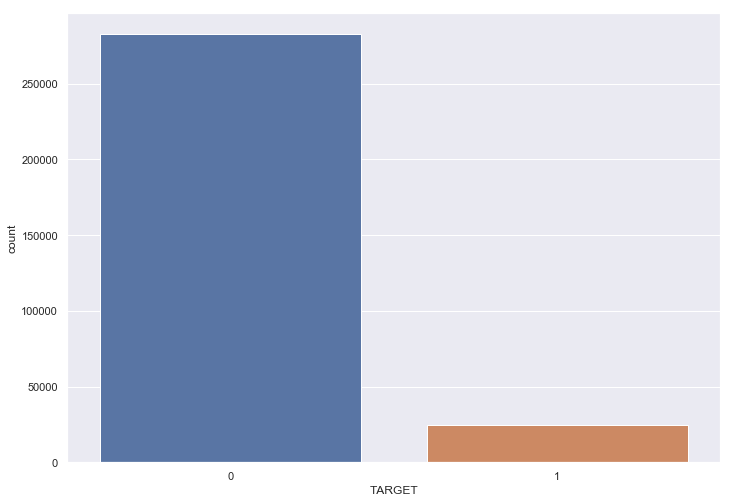

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.countplot(x="TARGET", data=application_train)

We can see that our data is highly skewed! (most applicants didn't have any payment difficulties)

---

### Missing values

In [5]:
def list_missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = ((total/df.SK_ID_CURR.count())*100).sort_values(ascending = False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', '%'], sort=True)
    missing_data = missing_data[(missing_data['%'] > 0)]
    return missing_data.sort_values(by='%', ascending=False)

missing_data_list = list_missing_data(application_all)
missing_data_list.head(50)

NameError: name 'application_all' is not defined

For now, we will not be using most of the columns with more than 60% missing values.

In [7]:
columns_to_ignore = missing_data_list[missing_data_list['%']>60].index.tolist()
columns_to_ignore

['COMMONAREA_AVG',
 'COMMONAREA_MODE',
 'COMMONAREA_MEDI',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MODE',
 'FONDKAPREMONT_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_MODE',
 'FLOORSMIN_MODE',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_AVG',
 'YEARS_BUILD_MODE',
 'YEARS_BUILD_MEDI',
 'YEARS_BUILD_AVG',
 'OWN_CAR_AGE']

In [4]:
application_train.drop([
    'FLAG_CONT_MOBILE',
    'FLAG_WORK_PHONE',
    'FLAG_PHONE',
    'FLAG_EMAIL',
    'APARTMENTS_AVG',
    'BASEMENTAREA_AVG',
    'YEARS_BEGINEXPLUATATION_AVG',
    'ELEVATORS_AVG',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'HOUR_APPR_PROCESS_START',
    'COMMONAREA_MODE',
    'COMMONAREA_MEDI',
    'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAPARTMENTS_MEDI',
    'NONLIVINGAPARTMENTS_MODE',
    'FONDKAPREMONT_MODE',
    'LIVINGAPARTMENTS_AVG',
    'LIVINGAPARTMENTS_MEDI',
    'LIVINGAPARTMENTS_MODE',
    'FLOORSMIN_MODE',
    'FLOORSMIN_MEDI',
    'FLOORSMIN_AVG',
    'YEARS_BUILD_MODE',
    'YEARS_BUILD_MEDI',
    'YEARS_BUILD_AVG',
    'COMMONAREA_AVG',
    'ENTRANCES_AVG', 
    'FLOORSMAX_AVG', 
    'LANDAREA_AVG', 
    'LIVINGAREA_AVG', 
    'NONLIVINGAREA_AVG', 
    'APARTMENTS_MODE', 
    'BASEMENTAREA_MODE', 
    'YEARS_BEGINEXPLUATATION_MODE',
    'ELEVATORS_MODE', 
    'ENTRANCES_MODE', 
    'FLOORSMAX_MODE', 
    'LANDAREA_MODE', 
    'LIVINGAREA_MODE', 
    'NONLIVINGAREA_MODE',
    'APARTMENTS_MEDI', 
    'BASEMENTAREA_MEDI', 
    'YEARS_BEGINEXPLUATATION_MEDI', 
    'ELEVATORS_MEDI', 
    'ENTRANCES_MEDI',
    'FLOORSMAX_MEDI', 
    'LANDAREA_MEDI', 
    'LIVINGAREA_MEDI', 
    'NONLIVINGAREA_MEDI', 
    'HOUSETYPE_MODE', 
    'TOTALAREA_MODE', 
    'WALLSMATERIAL_MODE' 
    ], axis=1, inplace=True)

### Outliers
We will now see if there are any outliers in the data (extreme/weird values..) 

#### CODE_GENDER

In [8]:
application_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [9]:
application_test['CODE_GENDER'].value_counts()

F    32678
M    16066
Name: CODE_GENDER, dtype: int64

We have a 4 rows with the CODE_GENDER value 'XNA' in the training set, we will remove them.

In [5]:
application_train = application_train[application_train['CODE_GENDER'] != 'XNA']
application_train['CODE_GENDER'].value_counts()

F    202448
M    105059
Name: CODE_GENDER, dtype: int64

#### NAME_FAMILY_STATUS

In [11]:
application_train['NAME_FAMILY_STATUS'].value_counts()

Married                 196429
Single / not married     45444
Civil marriage           29774
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

In [12]:
application_test['NAME_FAMILY_STATUS'].value_counts()

Married                 32283
Single / not married     7036
Civil marriage           4261
Separated                2955
Widow                    2209
Name: NAME_FAMILY_STATUS, dtype: int64

We have two people with 'Unknown' status in the training set, we will remove them.

In [6]:
application_train = application_train[application_train['NAME_FAMILY_STATUS'] != 'Unknown']
application_train['NAME_FAMILY_STATUS'].value_counts()

Married                 196429
Single / not married     45444
Civil marriage           29774
Separated                19770
Widow                    16088
Name: NAME_FAMILY_STATUS, dtype: int64

#### CNT_CHILDREN

In [14]:
application_all['CNT_CHILDREN'].describe() # 20 children?! Why not ..

count    356255.000000
mean          0.414316
std           0.720378
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: CNT_CHILDREN, dtype: float64

In [6]:
del application_all
gc.collect()

NameError: name 'application_all' is not defined

#### DAYS_EMPLOYED

In [16]:
(application_train['DAYS_EMPLOYED']/-365).describe() 

count    307505.000000
mean       -174.839312
std         387.059825
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [17]:
(application_test['DAYS_EMPLOYED']/-365).describe() 

count    48744.000000
mean      -184.891415
std        395.475362
min      -1000.665753
25%          0.810959
50%          3.542466
75%          7.972603
max         47.843836
Name: DAYS_EMPLOYED, dtype: float64

Here we have a wrong value for the current emplyment duration. We will remove this value

There are a lot of rows with this value. We will replace it with NaN for now, and later, when we will bin the column, we will place them in a seperate bin.

In [7]:
application_train['DAYS_EMPLOYED'] = application_train['DAYS_EMPLOYED'].replace(365243, np.NaN)
(application_train['DAYS_EMPLOYED']/-365).describe() 

count    252131.000000
mean          6.531933
std           6.406388
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [7]:
application_test['DAYS_EMPLOYED'] = application_test['DAYS_EMPLOYED'].replace(365243, np.NaN)
(application_test['DAYS_EMPLOYED']/-365).describe() 

NameError: name 'application_test' is not defined

#### OCCUPATION_TYPE

In [20]:
application_train['OCCUPATION_TYPE'].value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27569
Managers                 21370
Drivers                  18603
High skill tech staff    11380
Accountants               9812
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2092
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

In [21]:
application_test['OCCUPATION_TYPE'].value_counts()

Laborers                 8655
Sales staff              5072
Core staff               4361
Managers                 3574
Drivers                  2773
High skill tech staff    1854
Accountants              1628
Medicine staff           1316
Security staff            915
Cooking staff             894
Cleaning staff            656
Private service staff     455
Low-skill Laborers        272
Secretaries               213
Waiters/barmen staff      178
Realty agents             138
HR staff                  104
IT staff                   81
Name: OCCUPATION_TYPE, dtype: int64

We have the same categories for train/test sets

#### ORGANIZATION_TYPE

In [22]:
application_train['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11192
Business Entity Type 2    10552
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6879
Construction               6721
Business Entity Type 1     5983
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3277
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7           1307
Transpor

In [23]:
application_test['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    10840
XNA                        9274
Self-employed              5920
Other                      2707
Medicine                   1716
Government                 1508
Business Entity Type 2     1479
Trade: type 7              1303
School                     1287
Construction               1039
Kindergarten               1038
Business Entity Type 1      887
Transport: type 4           884
Trade: type 3               578
Military                    530
Industry: type 9            499
Industry: type 3            489
Security                    472
Transport: type 2           448
Police                      441
Housing                     435
Industry: type 11           416
Bank                        374
Security Ministries         341
Services                    302
Postal                      294
Agriculture                 292
Restaurant                  284
Trade: type 2               242
University                  221
Industry: type 7            217
Industry

#### AMT_INCOME_TOTAL

In [24]:
application_train['AMT_INCOME_TOTAL'].describe() 

count    3.075050e+05
mean     1.687967e+05
std      2.371248e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

In [25]:
application_test['AMT_INCOME_TOTAL'].describe() 

count    4.874400e+04
mean     1.784318e+05
std      1.015226e+05
min      2.694150e+04
25%      1.125000e+05
50%      1.575000e+05
75%      2.250000e+05
max      4.410000e+06
Name: AMT_INCOME_TOTAL, dtype: float64

We have some outliers in the training data (people making over 1M).

**Decomposition in the train set:**

In [26]:
print('Number of clients making more than 1M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 1000000)].count()))
print('Number of clients making more than 2M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 2000000)].count()))
print('Number of clients making more than 4M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 4000000)].count()))
print('Number of clients making more than 10M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 10000000)].count()))
print('Number of clients making more than 100M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 100000000)].count()))

Number of clients making more than 1M: 250
Number of clients making more than 2M: 44
Number of clients making more than 4M: 9
Number of clients making more than 10M: 3
Number of clients making more than 100M: 1


**Decomposition in the test set:**

In [27]:
print('Number of clients making more than 1M: {}'.format(application_test.AMT_INCOME_TOTAL[(application_test.AMT_INCOME_TOTAL > 1000000)].count()))
print('Number of clients making more than 2M: {}'.format(application_test.AMT_INCOME_TOTAL[(application_test.AMT_INCOME_TOTAL > 2000000)].count()))
print('Number of clients making more than 4M: {}'.format(application_test.AMT_INCOME_TOTAL[(application_test.AMT_INCOME_TOTAL > 4000000)].count()))
print('Number of clients making more than 10M: {}'.format(application_test.AMT_INCOME_TOTAL[(application_test.AMT_INCOME_TOTAL > 10000000)].count()))
print('Number of clients making more than 100M: {}'.format(application_test.AMT_INCOME_TOTAL[(application_test.AMT_INCOME_TOTAL > 100000000)].count()))

Number of clients making more than 1M: 38
Number of clients making more than 2M: 5
Number of clients making more than 4M: 1
Number of clients making more than 10M: 0
Number of clients making more than 100M: 0


We'll remove the entries of clients making more than 10M

In [8]:
application_train = application_train[(application_train.AMT_INCOME_TOTAL < 10000000)]

---

### Dataviz
In this part, we will visualize some data get general information about the data

#### Categorical features
First, we will deal with categorical features

##### NAME_CONTRACT_TYPE
Identification if loan is cash or revolving

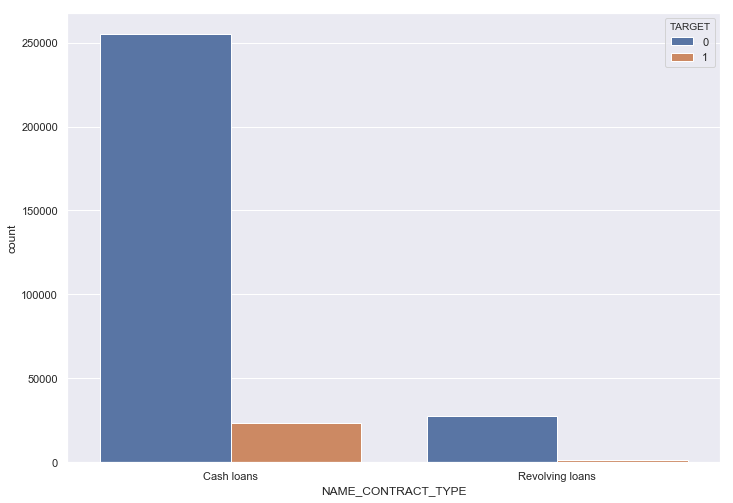

In [29]:
sns.countplot(x='NAME_CONTRACT_TYPE', hue='TARGET', data=application_train)

##### CODE_GENDER
Gender of the client

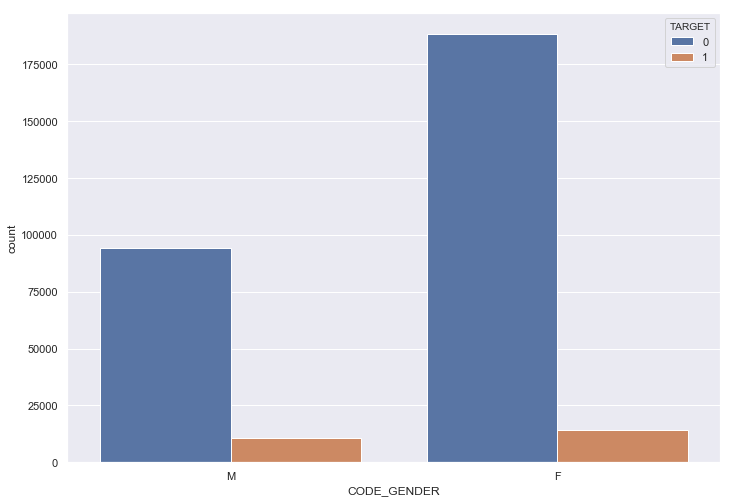

In [30]:
sns.countplot(x='CODE_GENDER', hue='TARGET', data=application_train)

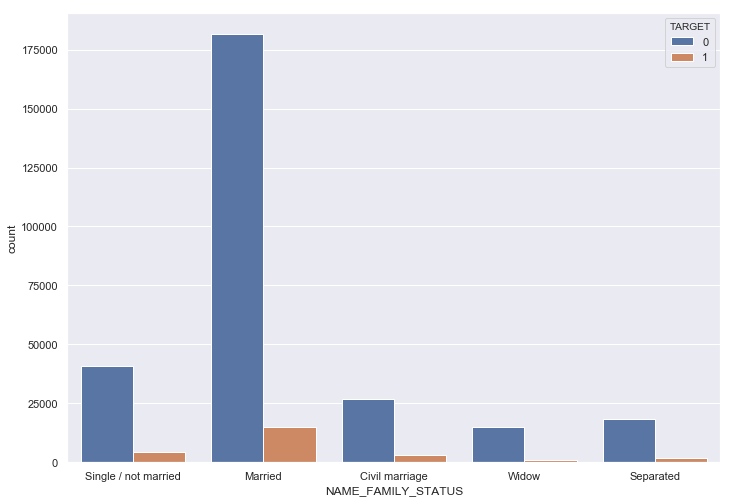

In [31]:
sns.countplot(x='NAME_FAMILY_STATUS', hue='TARGET', data=application_train)

##### FLAG_OWN_CAR
Flag if the client owns a car

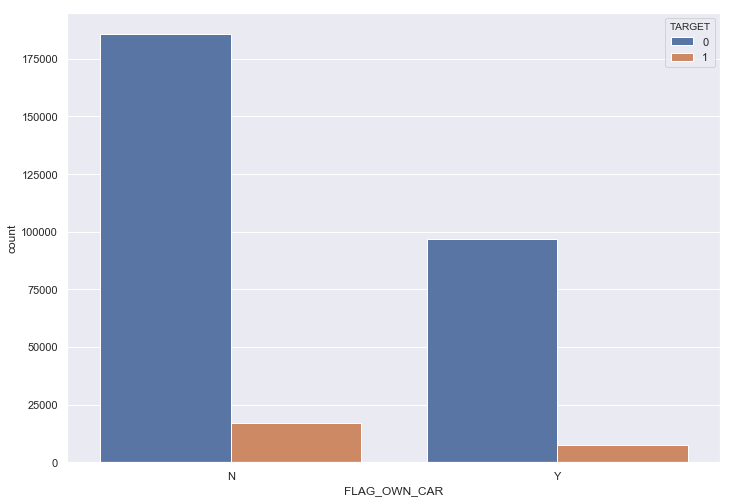

In [32]:
sns.countplot(x='FLAG_OWN_CAR', hue='TARGET', data=application_train)

##### FLAG_OWN_REALTY
Flag if client owns a house or flat

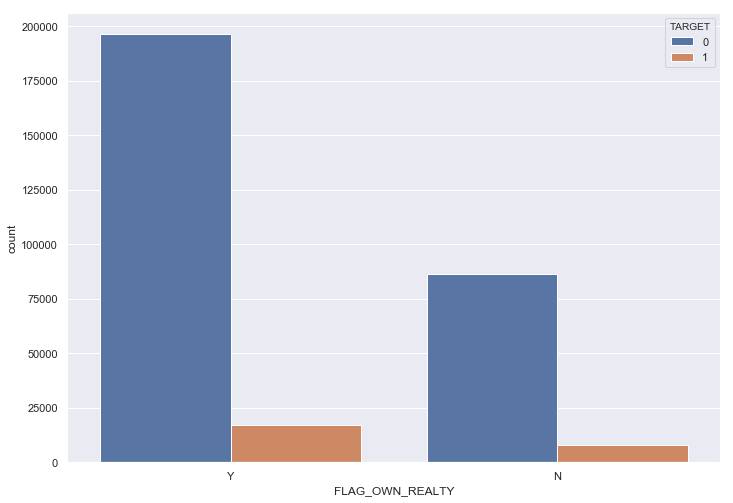

In [33]:
sns.countplot(x='FLAG_OWN_REALTY', hue='TARGET', data=application_train)

##### NAME_TYPE_SUITE
Who was accompanying client when he was applying for the loan

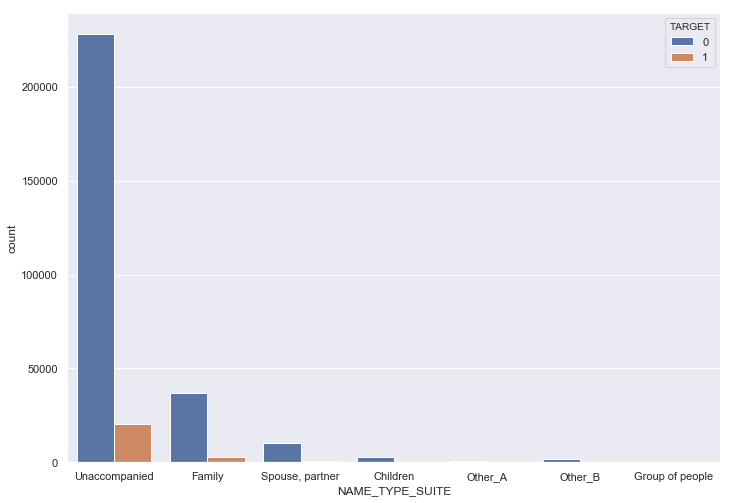

In [34]:
sns.countplot(x='NAME_TYPE_SUITE', hue='TARGET', data=application_train)

##### NAME_INCOME_TYPE
Clients income type (businessman, working, maternity leave,..)

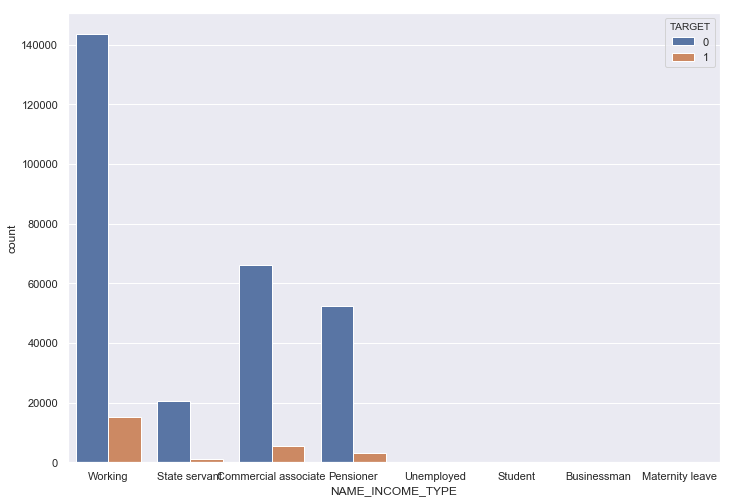

In [35]:
sns.countplot(x='NAME_INCOME_TYPE', hue='TARGET', data=application_train)

##### NAME_EDUCATION_TYPE
Level of highest education the client achieved

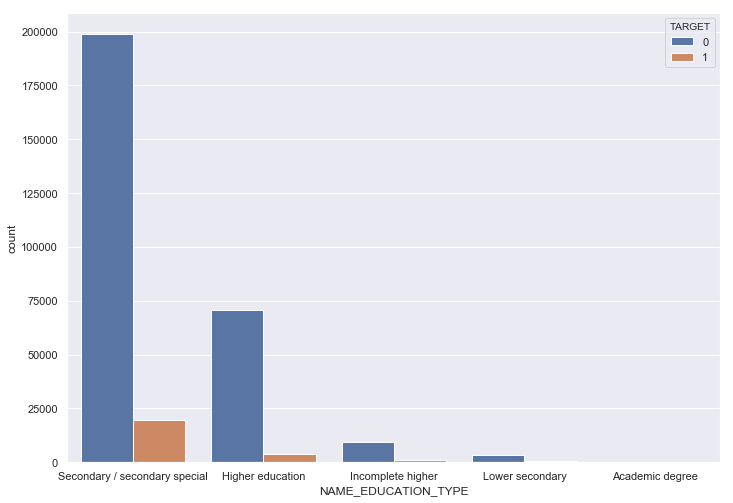

In [36]:
sns.countplot(x='NAME_EDUCATION_TYPE', hue='TARGET', data=application_train)

##### NAME_FAMILY_STATUS
Family status of the client

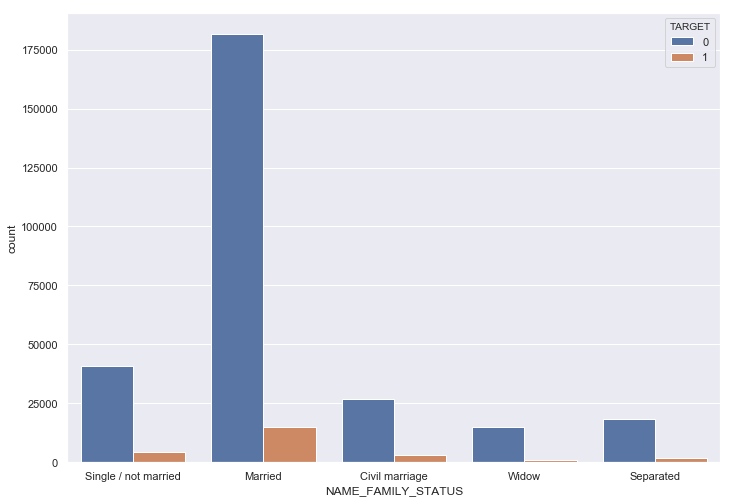

In [37]:
sns.countplot(x='NAME_FAMILY_STATUS', hue='TARGET', data=application_train)

##### NAME_HOUSING_TYPE
What is the housing situation of the client (renting, living with parents, ...)

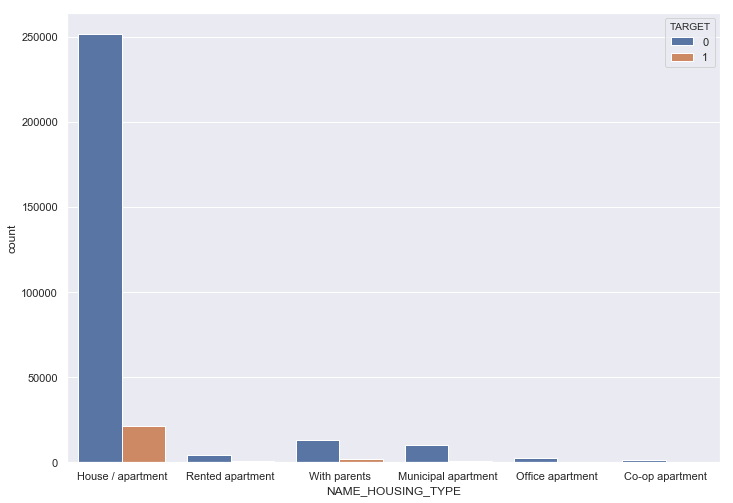

In [38]:
sns.countplot(x='NAME_HOUSING_TYPE', hue='TARGET', data=application_train)

##### OCCUPATION_TYPE
What kind of occupation does the client have

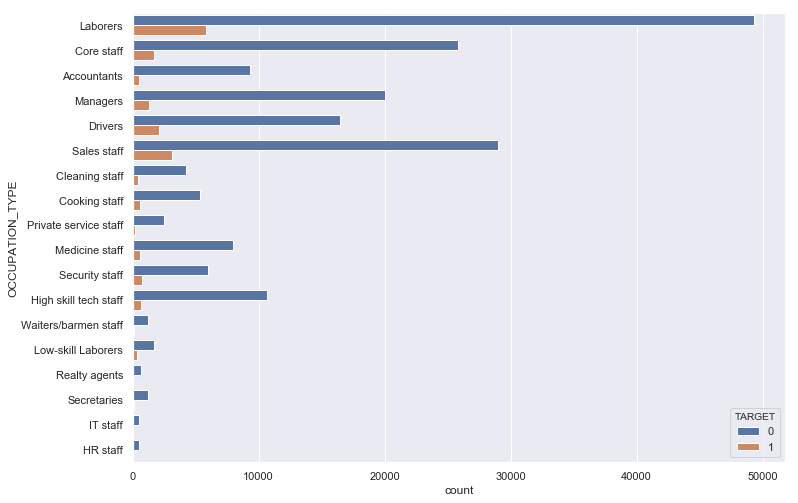

In [39]:
sns.countplot(y='OCCUPATION_TYPE', hue='TARGET', data=application_train)

##### WEEKDAY_APPR_PROCESS_START
On which day of the week did the client apply for the loan

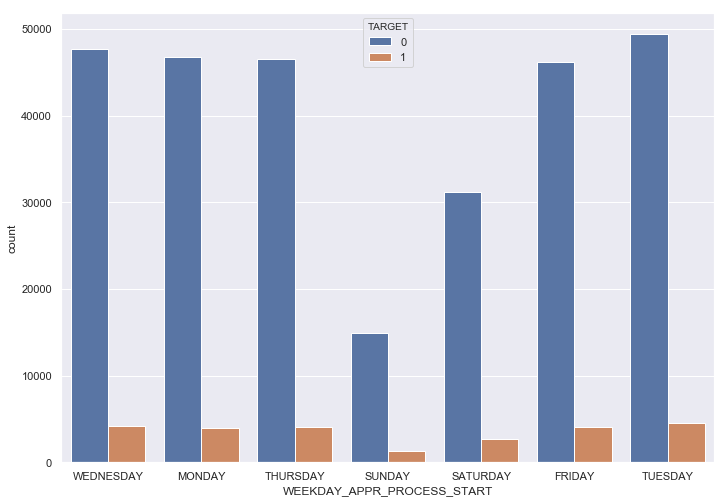

In [40]:
sns.countplot(x='WEEKDAY_APPR_PROCESS_START', hue='TARGET', data=application_train)

##### ORGANIZATION_TYPE
Type of organization where client works

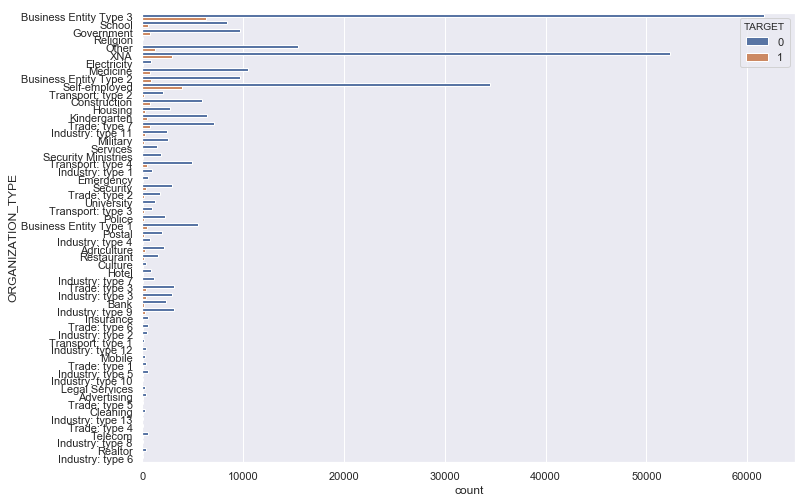

In [41]:
sns.countplot(y='ORGANIZATION_TYPE', hue='TARGET', data=application_train)

#### Numerical features
In this section, we will explore the numerical features 

##### AMT_INCOME_TOTAL
Income of the client

**Income distribution for the 0-800K range**

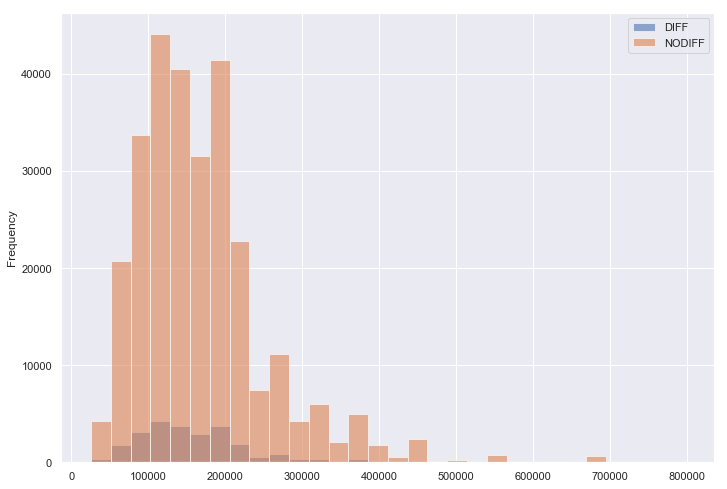

In [42]:
diff_AMT_INCOME_TOTAL = (application_train[application_train.TARGET == 1].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL < 800000)])
nodiff_AMT_INCOME_TOTAL = (application_train[application_train.TARGET == 0].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL < 800000)])

pd.DataFrame(
{'DIFF': diff_AMT_INCOME_TOTAL,
 'NODIFF': nodiff_AMT_INCOME_TOTAL},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 30,alpha=0.6)
plt.show()

**Income distribution for the 800K-2M range**

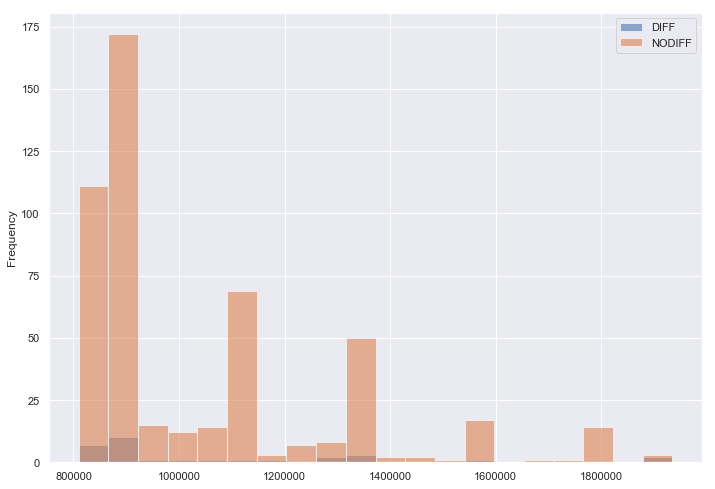

In [43]:
pd.DataFrame(
{'DIFF': application_train[application_train.TARGET == 1].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 800000) & (application_train.AMT_INCOME_TOTAL < 2000000)],
 'NODIFF': application_train[application_train.TARGET == 0].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 800000) & (application_train.AMT_INCOME_TOTAL < 2000000)]},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

**Income distribution for the 2M+ range**

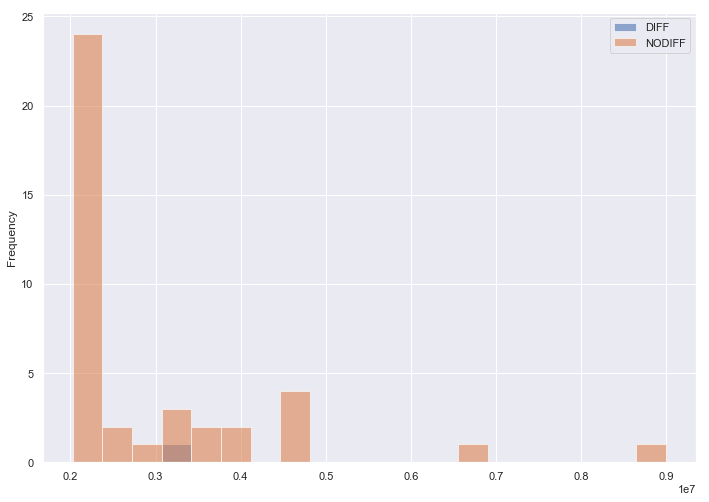

In [44]:
pd.DataFrame(
{'DIFF': application_train[application_train.TARGET == 1].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 2000000)],
 'NODIFF': application_train[application_train.TARGET == 0].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 2000000)]},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

#### AMT_CREDIT
Credit amount of the loan

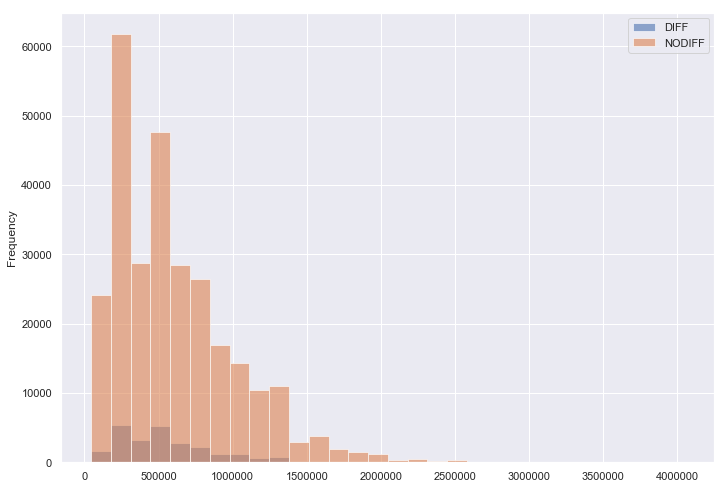

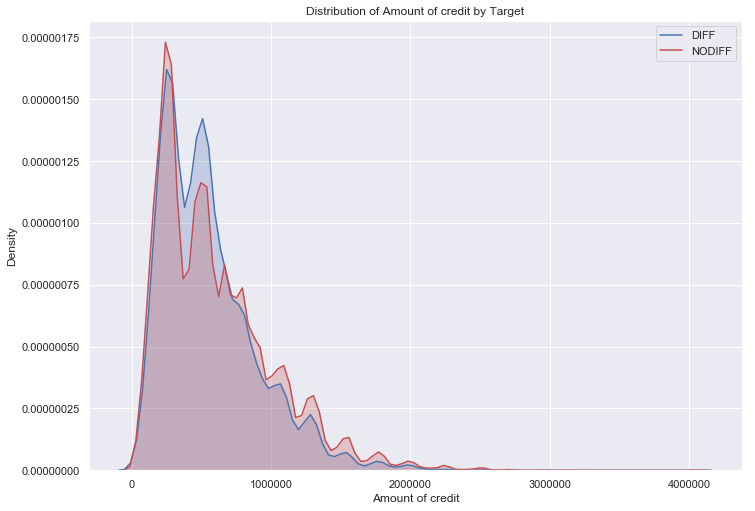

In [45]:
diff_AMT_CREDIT = application_train[(application_train.TARGET == 1) & (application_train.AMT_CREDIT.notnull())].AMT_CREDIT
nodiff_AMT_CREDIT = application_train[(application_train.TARGET == 0) & (application_train.AMT_CREDIT.notnull())].AMT_CREDIT

pd.DataFrame(
{'DIFF': diff_AMT_CREDIT,
 'NODIFF': nodiff_AMT_CREDIT},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 30,alpha=0.6)
plt.show()


plt.subplot(1, 1, 1)
sns.kdeplot(diff_AMT_CREDIT,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_AMT_CREDIT, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of Amount of credit by Target')
plt.xlabel('Amount of credit'); 
plt.ylabel('Density');

#### DAYS_BIRTH
Client's age in days at the time of application

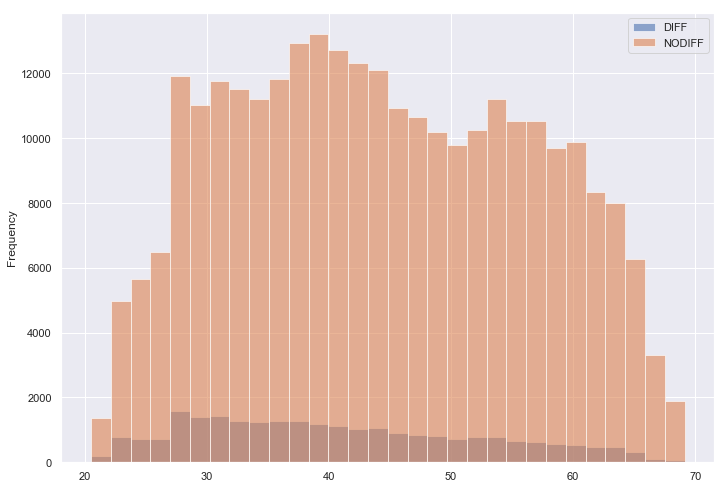

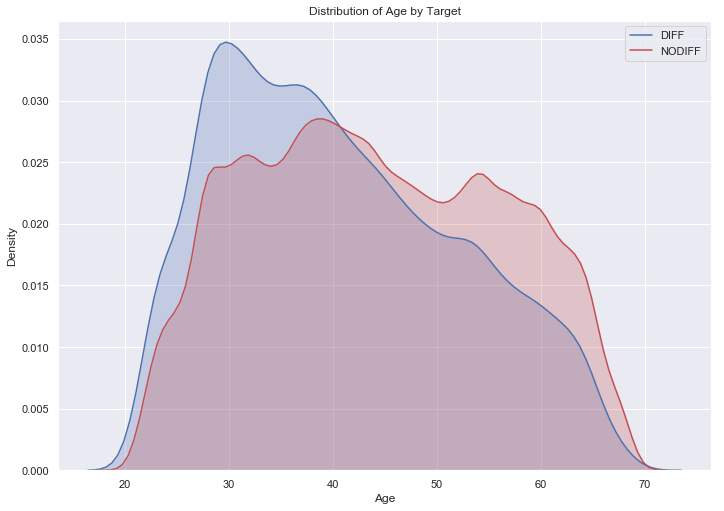

In [46]:
diff_DAYS_BIRTH = (application_train[application_train.TARGET == 1].DAYS_BIRTH/-365)
nodiff_DAYS_BIRTH = (application_train[application_train.TARGET == 0].DAYS_BIRTH/-365)

pd.DataFrame(
{'DIFF': diff_DAYS_BIRTH,
 'NODIFF': nodiff_DAYS_BIRTH},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 30,alpha=0.6)
plt.show()


plt.subplot(1, 1, 1)
sns.kdeplot(diff_DAYS_BIRTH,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_DAYS_BIRTH, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of Age by Target')
plt.xlabel('Age'); 
plt.ylabel('Density');

Younger people relatively have more difficulties

#### DAYS_EMPLOYED
How many days before the application the person started current employment

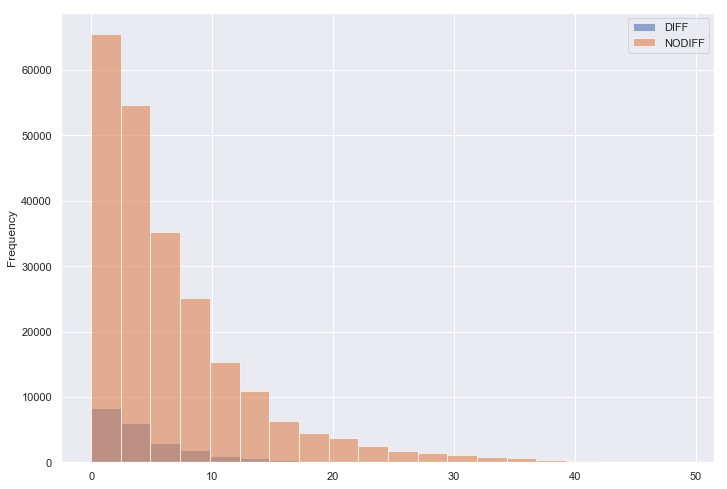

In [47]:
diff_DAYS_EMPLOYED = application_train[(application_train.TARGET == 1) & (application_train.DAYS_EMPLOYED.notnull())].DAYS_EMPLOYED/-365
nodiff_DAYS_EMPLOYED = application_train[(application_train.TARGET == 0) & (application_train.DAYS_EMPLOYED.notnull())].DAYS_EMPLOYED/-365

pd.DataFrame(
{'DIFF': diff_DAYS_EMPLOYED,
 'NODIFF': nodiff_DAYS_EMPLOYED},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

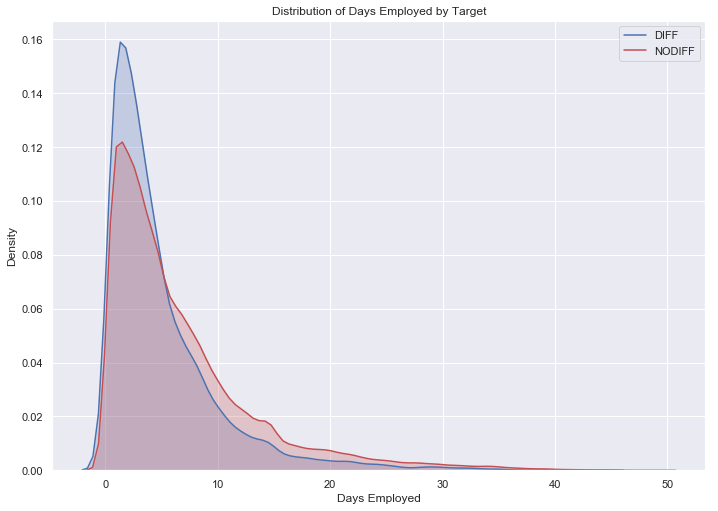

In [48]:
plt.subplot(1, 1, 1)
sns.kdeplot(diff_DAYS_EMPLOYED,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_DAYS_EMPLOYED, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of Days Employed by Target')
plt.xlabel('Days Employed'); 
plt.ylabel('Density');

 #### EXT_SOURCE_{1|2|3}
 Normalized score from external data source

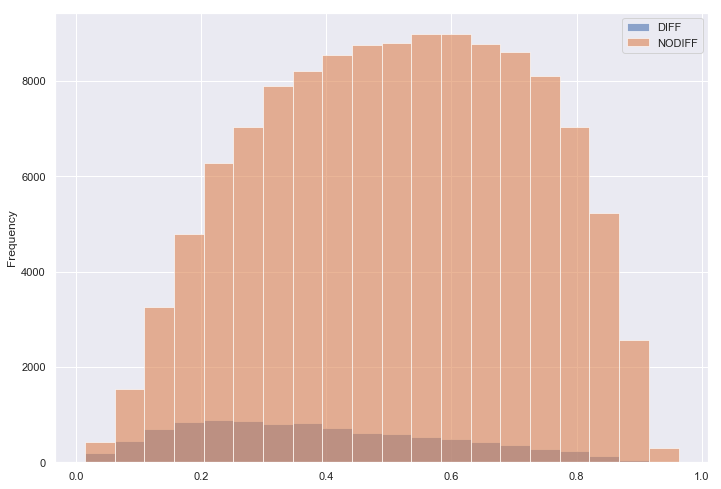

In [49]:
diff_EXT_SOURCE_1 = application_train[(application_train.TARGET == 1) & (application_train.EXT_SOURCE_1.notnull())].EXT_SOURCE_1
nodiff_EXT_SOURCE_1 = application_train[(application_train.TARGET == 0) & (application_train.EXT_SOURCE_1.notnull())].EXT_SOURCE_1


pd.DataFrame(
{'DIFF': diff_EXT_SOURCE_1
,
 'NODIFF': nodiff_EXT_SOURCE_1
},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

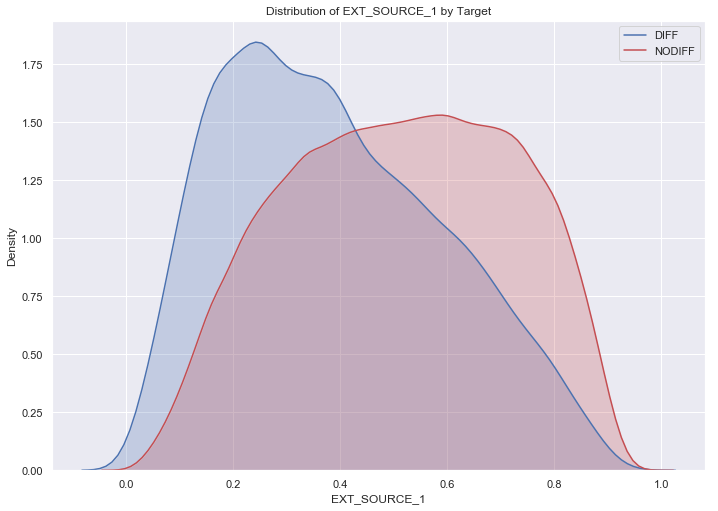

In [50]:
plt.subplot(1, 1, 1)
sns.kdeplot(diff_EXT_SOURCE_1,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_EXT_SOURCE_1, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of EXT_SOURCE_1 by Target')
plt.xlabel('EXT_SOURCE_1'); 
plt.ylabel('Density');

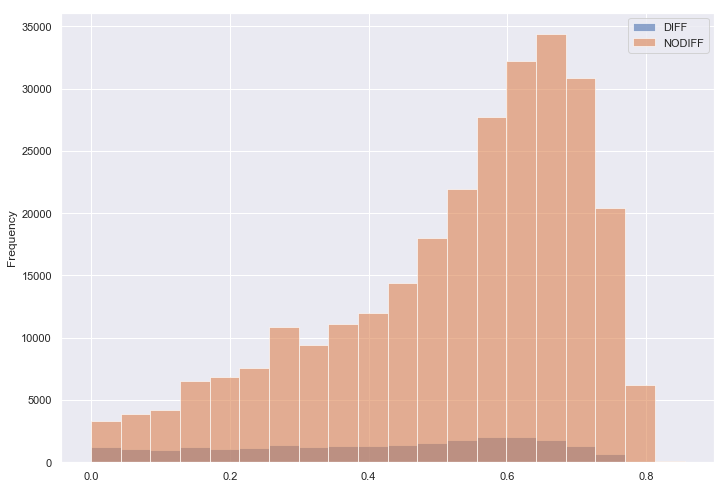

In [51]:
diff_EXT_SOURCE_2 = application_train[(application_train.TARGET == 1) & (application_train.EXT_SOURCE_2.notnull())].EXT_SOURCE_2
nodiff_EXT_SOURCE_2 = application_train[(application_train.TARGET == 0) & (application_train.EXT_SOURCE_2.notnull())].EXT_SOURCE_2


pd.DataFrame(
{'DIFF': diff_EXT_SOURCE_2
,
 'NODIFF': nodiff_EXT_SOURCE_2
},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

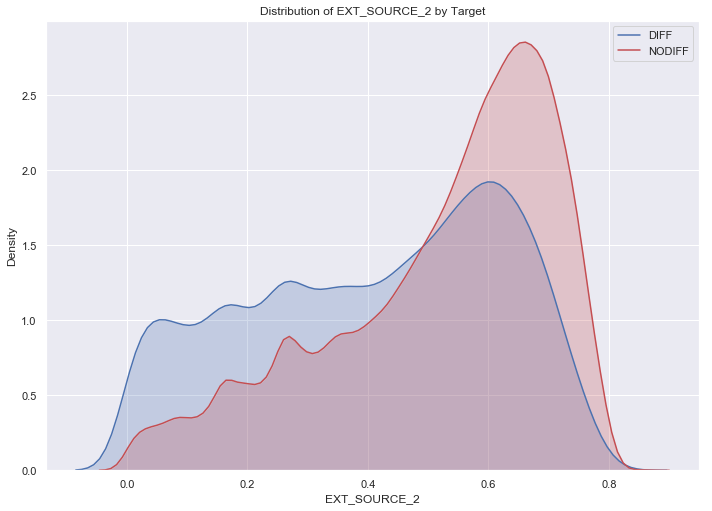

In [52]:
plt.subplot(1, 1, 1)
sns.kdeplot(diff_EXT_SOURCE_2,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_EXT_SOURCE_2, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of EXT_SOURCE_2 by Target')
plt.xlabel('EXT_SOURCE_2'); 
plt.ylabel('Density');

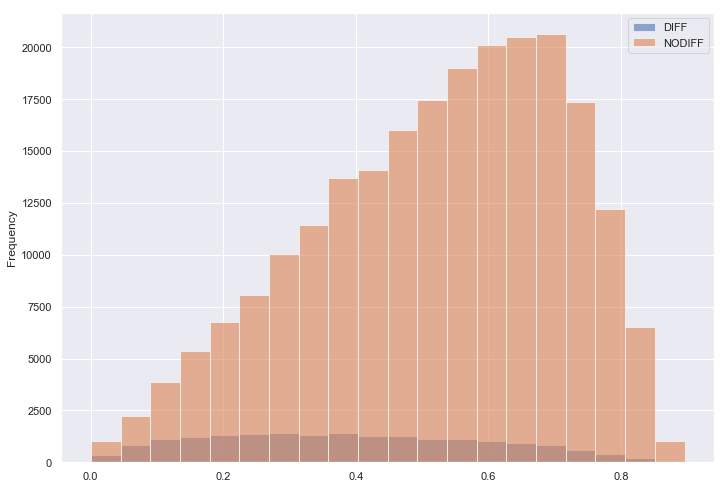

In [53]:
diff_EXT_SOURCE_3 = application_train[(application_train.TARGET == 1) & (application_train.EXT_SOURCE_3.notnull())].EXT_SOURCE_3
nodiff_EXT_SOURCE_3 = application_train[(application_train.TARGET == 0) & (application_train.EXT_SOURCE_3.notnull())].EXT_SOURCE_3
pd.DataFrame(
{'DIFF': diff_EXT_SOURCE_3
,
 'NODIFF': nodiff_EXT_SOURCE_3
},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

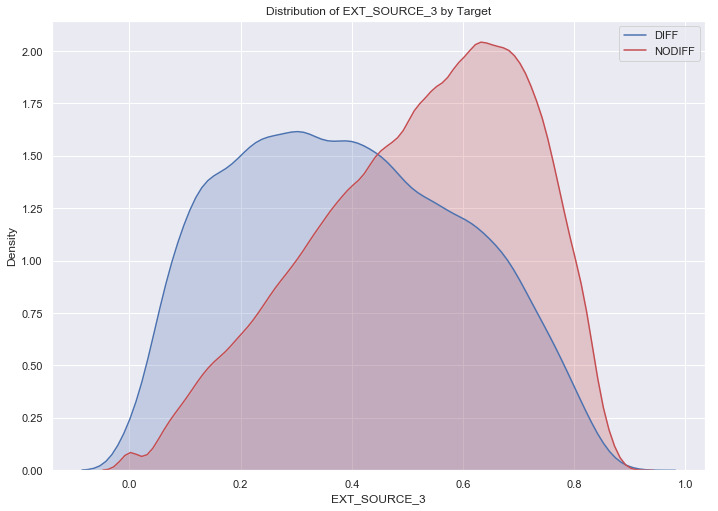

In [54]:
plt.subplot(1, 1, 1)
sns.kdeplot(diff_EXT_SOURCE_3,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_EXT_SOURCE_3, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of EXT_SOURCE_3 by Target')
plt.xlabel('EXT_SOURCE_3'); 
plt.ylabel('Density');

Lower scores have more difficulties and vice versa.

---

### Data preparation
In this part, we will process our data (encode the categorical features, bin continuous features, deal with nulls.. etc)
We will focus on the following features: 
*AMT_INCOME_TOTAL,
AMT_CREDIT,
AMT_ANNUITY,
DAYS_BIRTH,
DAYS_EMPLOYED,
CNT_FAM_MEMBERS,
DAYS_LAST_PHONE_CHANGE,
OWN_CAR_AGE,

EXT_SOURCE_{1|2|3},
REGION_RATING_CLIENT,
REGION_RATING_CLIENT_W_CITY,
LIVE_REGION_NOT_WORK_REGION,
REG_CITY_NOT_LIVE_CITY,
REG_CITY_NOT_WORK_CITY,
LIVE_CITY_NOT_WORK_CITY,

NAME_CONTRACT_TYPE,
CODE_GENDER,
FLAG_OWN_CAR,
FLAG_OWN_REALTY,
NAME_TYPE_SUITE,
NAME_INCOME_TYPE,
NAME_EDUCATION_TYPE,
NAME_FAMILY_STATUS,
NAME_HOUSING_TYPE,
OCCUPATION_TYPE,
ORGANIZATION_TYPE*

In [9]:
categorical_features=[
    'FLAG_OWN_CAR',
    'CODE_GENDER',
    'FLAG_OWN_REALTY',
    'NAME_CONTRACT_TYPE',
    'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE',
    'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY',
    'LIVE_CITY_NOT_WORK_CITY',
    'REGION_RATING_CLIENT',
    'REGION_RATING_CLIENT_W_CITY'
]

application_train_proc = application_train[['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE','OWN_CAR_AGE'] + categorical_features]

for col in categorical_features:
    application_train_proc.loc[:,col], uniques = pd.factorize(application_train_proc[col])

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [10]:
application_train_proc.head()

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OWN_CAR_AGE,FLAG_OWN_CAR,CODE_GENDER,FLAG_OWN_REALTY,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY
0,1,202500.0,406597.5,24700.5,-9461,-637.0,1.0,0.083037,0.262949,0.139376,-1134.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,270000.0,1293502.5,35698.5,-16765,-1188.0,2.0,0.311267,0.622246,NaN,-828.0,NaN,0,1,1,0,1,1,1,1,0,1,1,0,0,0,1,1
2,0,67500.0,135000.0,6750.0,-19046,-225.0,1.0,NaN,0.555912,0.729567,-815.0,26.0,1,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0
3,0,135000.0,312682.5,29686.5,-19005,-3039.0,2.0,NaN,0.650442,NaN,-617.0,NaN,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0
4,0,121500.0,513000.0,21865.5,-19932,-3038.0,1.0,NaN,0.322738,NaN,-1106.0,NaN,0,0,0,0,0,0,0,0,0,1,3,0,1,1,0,0


### Correlation map

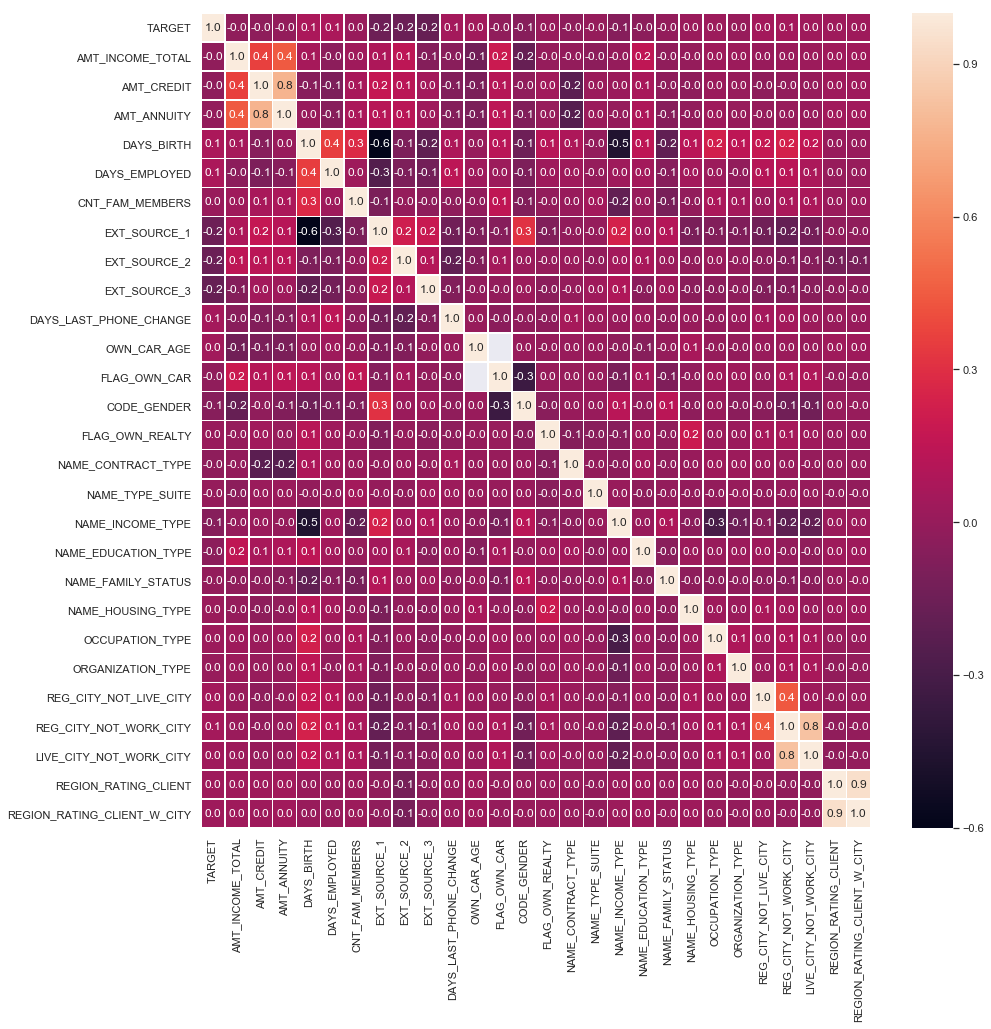

In [57]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(application_train_proc.corr(), annot=True, linewidths=.7, fmt= '.1f',ax=ax)
plt.show()

---

# Predictive model using Application table 
We will use features from the *'application'* table only to predict probabilities of credit default risk with the help of LightGBM.

## Using simple features
In this part, we will only use simple features for our predictions

In [11]:
n_folds = 5
folds = StratifiedKFold(n_splits= n_folds, shuffle=True, random_state= 666)

params ={
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005,
    'num_leaves': 52,
    'max_depth': 12,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.45,
    'reg_lambda': 0.48,
    'colsample_bytree': 0.5,
    'min_split_gain': 0.025,
    'subsample': 1
}

In [12]:
def plot_roc_auc(fpr,tpr,roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def plot_feat_importance(feat_importance_df):
    cols = feat_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index
    best_features = feat_importance_df.loc[feat_importance_df.feature.isin(cols)]
    plt.figure(figsize=(15, 20))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM feature importance (avg over folds)')
    

def lightgbm_model(df_train,categorical_feat,rounds=100):
    # Spliting training data into features/labels 
    app_train_proc_feat, app_train_proc_lbl = df_train.loc[:,df_train.columns != 'TARGET'], df_train.loc[:,'TARGET']

    avg_score = 0
    fprs = []
    tprs = []
    roc_aucs = []
    importance_df = pd.DataFrame()
    
    for n_fold, (train_idx, cv_idx) in enumerate(folds.split(app_train_proc_feat, app_train_proc_lbl)):
        # Train data
        train_feats = app_train_proc_feat.iloc[train_idx]
        train_lbls = app_train_proc_lbl.iloc[train_idx]

        # Cross-validation data
        cv_feats = app_train_proc_feat.iloc[cv_idx]
        cv_lbls = app_train_proc_lbl.iloc[cv_idx]
        
        # Features
        feats = app_train_proc_feat.columns

        # LightGBM classifier
        lgbm = LGBMClassifier(**params)

        start = time.time()
        # Fitting the model
        lgbm.fit(train_feats, train_lbls, eval_set=[(train_feats, train_lbls), (cv_feats, cv_lbls)],
                        eval_metric='auc', verbose=400, early_stopping_rounds=rounds,
                        feature_name=list(feats), categorical_feature=categorical_feat)
        end = time.time()

        # Testing the model on the CV data
        preds = lgbm.predict_proba(cv_feats, num_iteration=lgbm.best_iteration_)[:, 1]

        # Scores
        roc_auc = roc_auc_score(cv_lbls, preds)
        fpr, tpr, threshold = roc_curve(cv_lbls, preds)
        
        fprs.append(fpr)
        tprs.append(tpr)
        roc_aucs.append(roc_auc)

        avg_score += (roc_auc/n_folds)
        
        # Feature importance
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = feats
        fold_importance["importance"] = lgbm.feature_importances_
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        

        print('Training time: %.2f seconds' % (end-start))
        print('Fold %2d AUC : %.6f' % (n_fold, roc_auc))

        del lgbm, train_feats, train_lbls, cv_feats, cv_lbls, fold_importance
        gc.collect()


    print('Average score on folds: %.6f' % avg_score)
    
    return avg_score, fprs, tprs, roc_aucs, importance_df



In [64]:
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(application_train_proc,categorical_features,100)

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.248884	training's auc: 0.765076	valid_1's binary_logloss: 0.252206	valid_1's auc: 0.749224
[800]	training's binary_logloss: 0.241761	training's auc: 0.778439	valid_1's binary_logloss: 0.248378	valid_1's auc: 0.752702
[1200]	training's binary_logloss: 0.237559	training's auc: 0.789868	valid_1's binary_logloss: 0.24741	valid_1's auc: 0.754133
[1600]	training's binary_logloss: 0.23411	training's auc: 0.800348	valid_1's binary_logloss: 0.247009	valid_1's auc: 0.754995
[2000]	training's binary_logloss: 0.231058	training's auc: 0.809951	valid_1's binary_logloss: 0.246822	valid_1's auc: 0.755458
[2400]	training's binary_logloss: 0.228237	training's auc: 0.81878	valid_1's binary_logloss: 0.246723	valid_1's auc: 0.755689
Early stopping, best iteration is:
[2435]	training's binary_logloss: 0.228011	training's auc: 0.819486	valid_1's binary_logloss: 0.246701	valid_1's auc: 0.755756
Training time: 106

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.248379	training's auc: 0.766396	valid_1's binary_logloss: 0.25365	valid_1's auc: 0.742571
[800]	training's binary_logloss: 0.241178	training's auc: 0.779653	valid_1's binary_logloss: 0.250187	valid_1's auc: 0.746742
[1200]	training's binary_logloss: 0.236964	training's auc: 0.791138	valid_1's binary_logloss: 0.249373	valid_1's auc: 0.748375
[1600]	training's binary_logloss: 0.233485	training's auc: 0.801757	valid_1's binary_logloss: 0.249058	valid_1's auc: 0.74925
[2000]	training's binary_logloss: 0.230436	training's auc: 0.811289	valid_1's binary_logloss: 0.248957	valid_1's auc: 0.749523
Early stopping, best iteration is:
[1924]	training's binary_logloss: 0.230998	training's auc: 0.809512	valid_1's binary_logloss: 0.248954	valid_1's auc: 0.749556
Training time: 84.34 seconds
Fold  1 AUC : 0.749556


c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.248889	training's auc: 0.764899	valid_1's binary_logloss: 0.252057	valid_1's auc: 0.751002
[800]	training's binary_logloss: 0.241771	training's auc: 0.778069	valid_1's binary_logloss: 0.248283	valid_1's auc: 0.753915
[1200]	training's binary_logloss: 0.237615	training's auc: 0.789326	valid_1's binary_logloss: 0.247286	valid_1's auc: 0.755454
[1600]	training's binary_logloss: 0.234195	training's auc: 0.799709	valid_1's binary_logloss: 0.246813	valid_1's auc: 0.756624
[2000]	training's binary_logloss: 0.231157	training's auc: 0.809448	valid_1's binary_logloss: 0.246622	valid_1's auc: 0.757123
[2400]	training's binary_logloss: 0.228386	training's auc: 0.818229	valid_1's binary_logloss: 0.246487	valid_1's auc: 0.757475
[2800]	training's binary_logloss: 0.22574	training's auc: 0.826545	valid_1's binary_logloss: 0.246401	valid_1's auc: 0.757722
Early stopping, best iteration is:
[2951]	training'

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.24893	training's auc: 0.764993	valid_1's binary_logloss: 0.252172	valid_1's auc: 0.748644
[800]	training's binary_logloss: 0.241807	training's auc: 0.77847	valid_1's binary_logloss: 0.248162	valid_1's auc: 0.752713
[1200]	training's binary_logloss: 0.237609	training's auc: 0.789991	valid_1's binary_logloss: 0.246994	valid_1's auc: 0.754881
[1600]	training's binary_logloss: 0.234163	training's auc: 0.800502	valid_1's binary_logloss: 0.246417	valid_1's auc: 0.756372
[2000]	training's binary_logloss: 0.23112	training's auc: 0.810119	valid_1's binary_logloss: 0.24617	valid_1's auc: 0.756968
[2400]	training's binary_logloss: 0.22833	training's auc: 0.819018	valid_1's binary_logloss: 0.246027	valid_1's auc: 0.757367
[2800]	training's binary_logloss: 0.225658	training's auc: 0.827402	valid_1's binary_logloss: 0.245903	valid_1's auc: 0.757737
[3200]	training's binary_logloss: 0.223075	training's a

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.248583	training's auc: 0.766071	valid_1's binary_logloss: 0.253155	valid_1's auc: 0.743868
[800]	training's binary_logloss: 0.241492	training's auc: 0.779097	valid_1's binary_logloss: 0.249497	valid_1's auc: 0.748209
[1200]	training's binary_logloss: 0.237274	training's auc: 0.790682	valid_1's binary_logloss: 0.248401	valid_1's auc: 0.750701
[1600]	training's binary_logloss: 0.233823	training's auc: 0.80121	valid_1's binary_logloss: 0.247955	valid_1's auc: 0.751991
[2000]	training's binary_logloss: 0.230719	training's auc: 0.810891	valid_1's binary_logloss: 0.247725	valid_1's auc: 0.752716
[2400]	training's binary_logloss: 0.227922	training's auc: 0.819741	valid_1's binary_logloss: 0.247628	valid_1's auc: 0.753007
Early stopping, best iteration is:
[2414]	training's binary_logloss: 0.227829	training's auc: 0.820026	valid_1's binary_logloss: 0.247626	valid_1's auc: 0.753014
Training time: 1

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



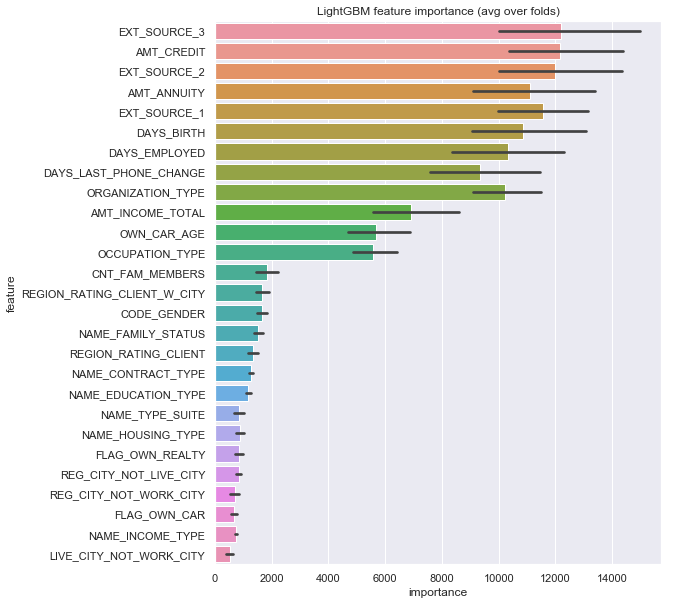

In [65]:
plot_feat_importance(feat_importance)

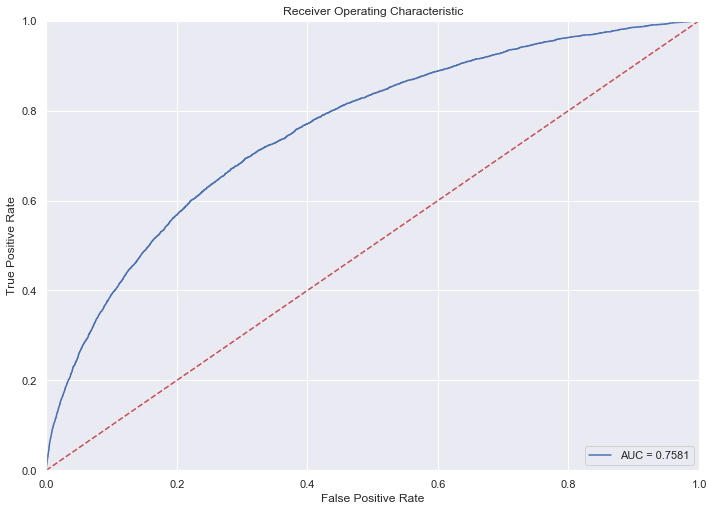

In [66]:
plot_roc_auc(fprs[3], tprs[3],roc_aucs[3])

We get an AUC of about **0.755** using LightGBM and basic features. Next we will try to come up with some engineered features to help improve this score!

## Using engineered features
In this part, we will use simple features as well as engineered features for our predictions

### Document count
A count of the documents provided by the client

In [12]:
docs = [cl for cl in application_train.columns if 'FLAG_DOCUMENT_' in cl]
application_train_proc['DOC_COUNT'] = application_train[docs].replace(np.nan,0).sum(axis=1)

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [61]:
corr = application_train_proc['TARGET'].corr(application_train_proc['DOC_COUNT'])
print('Document count correlation: %.4f' % corr)

Document count correlation: 0.0172


### External sources product cube root
The cube root of the EXT_SOURCES_{1|2|3} product

In [13]:
application_train_proc['EXT_SOURCES_PROD_CBRT'] = (application_train_proc['EXT_SOURCE_1']*application_train_proc['EXT_SOURCE_2']*application_train_proc['EXT_SOURCE_3'])**(1/3)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [63]:
corr = application_train_proc['TARGET'].corr(application_train_proc['EXT_SOURCES_PROD_CBRT'])
print('External sources product cube root correlation: %.4f' % corr)

External sources product cube root correlation: -0.2326


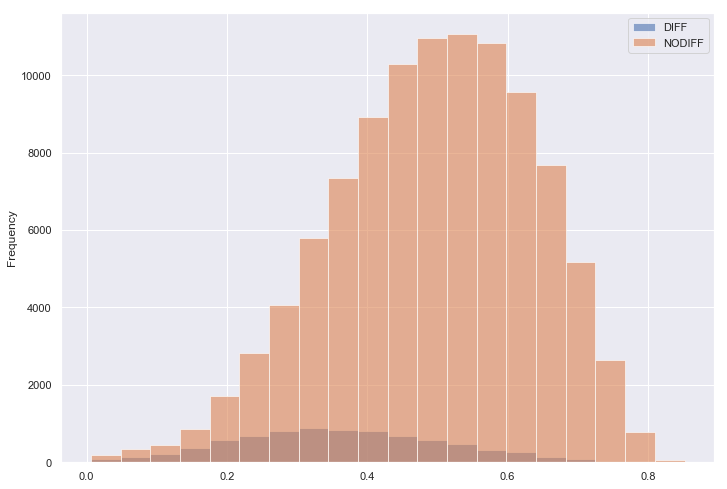

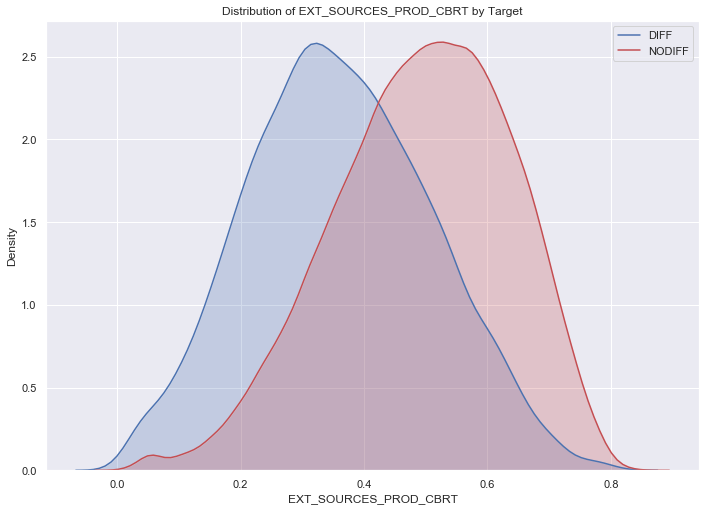

In [65]:
diff_EXT_SOURCES_PROD_CBRT = application_train_proc[(application_train_proc.TARGET == 1) & (application_train_proc.EXT_SOURCES_PROD_CBRT.notnull())].EXT_SOURCES_PROD_CBRT
nodiff_EXT_SOURCES_PROD_CBRT = application_train_proc[(application_train_proc.TARGET == 0) & (application_train_proc.EXT_SOURCES_PROD_CBRT.notnull())].EXT_SOURCES_PROD_CBRT


pd.DataFrame(
{'DIFF': diff_EXT_SOURCES_PROD_CBRT
,
 'NODIFF': nodiff_EXT_SOURCES_PROD_CBRT
},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

plt.subplot(1, 1, 1)
sns.kdeplot(diff_EXT_SOURCES_PROD_CBRT,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_EXT_SOURCES_PROD_CBRT, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of EXT_SOURCES_PROD_CBRT by Target')
plt.xlabel('EXT_SOURCES_PROD_CBRT'); 
plt.ylabel('Density');

### External sources statistics
Min, Max, Mean, Median and Variance of EXT_SOURCES_{1|2|3}

In [14]:
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    application_train_proc[feature_name] = eval('np.{}'.format(function_name))(
        application_train_proc[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:3250: RuntimeWarning:

All-NaN slice encountered



In [15]:
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    corr = application_train_proc['TARGET'].corr(application_train_proc[feature_name])
    print('External sources {} correlation: {}'.format(function_name, corr))

External sources min correlation: -0.1852548727526112
External sources max correlation: -0.1968678224623825
External sources mean correlation: -0.22203720878424357
External sources nanmedian correlation: -0.2180973924991173
External sources var correlation: 0.03357424133098887


### Years to pay
Years left to pay off the credit

In [16]:
application_train_proc['YEARS_TO_PAY'] = application_train_proc['AMT_CREDIT'] / application_train_proc['AMT_ANNUITY']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [69]:
corr = application_train_proc['TARGET'].corr(application_train_proc['YEARS_TO_PAY'])
print('Years to pay correlation: %.4f' % corr)

Years to pay correlation: -0.0321


### Down Payment
The down payment for the loan

In [17]:
application_train_proc['DOWN_PAYMENT'] = application_train['AMT_GOODS_PRICE']-application_train_proc['AMT_CREDIT']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [72]:
corr = application_train_proc['TARGET'].corr(application_train_proc['DOWN_PAYMENT'])
print('Down Payment correlation: %.4f' % corr)

Down Payment correlation: -0.0342


### Ratios
Retios of various contiuous features with eachother

In [18]:
application_train_proc['CREDIT_TO_GOODS_RATIO'] = application_train_proc['AMT_CREDIT']/application_train['AMT_GOODS_PRICE']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [74]:
corr = application_train_proc['TARGET'].corr(application_train_proc['CREDIT_TO_GOODS_RATIO'])
print('Credit To Goods Ratio correlation: %.4f' % corr)

Credit To Goods Ratio correlation: 0.0694


In [19]:
application_train_proc['ANNUITY_TO_INCOME_RATIO'] = application_train_proc['AMT_ANNUITY'] / application_train_proc['AMT_INCOME_TOTAL']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [76]:
corr = application_train_proc['TARGET'].corr(application_train_proc['ANNUITY_TO_INCOME_RATIO'])
print('Annuity To Income Ratio correlation: %.4f' % corr)

Annuity To Income Ratio correlation: 0.0143


In [20]:
application_train_proc['EMPLOYED_TO_BIRTH_RATIO'] = application_train_proc['DAYS_EMPLOYED'] / application_train_proc['DAYS_BIRTH']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [78]:
corr = application_train_proc['TARGET'].corr(application_train_proc['EMPLOYED_TO_BIRTH_RATIO'])
print('Employed To Birth Ratio correlation: %.4f' % corr)

Employed To Birth Ratio correlation: -0.0679


In [21]:
application_train_proc['CAR_TO_BIRTH_RATIO'] = application_train['OWN_CAR_AGE'] / application_train_proc['DAYS_BIRTH']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [80]:
corr = application_train_proc['TARGET'].corr(application_train_proc['CAR_TO_BIRTH_RATIO'])
print('Car To Birth Ratio correlation: %.4f' % corr)

Car To Birth Ratio correlation: -0.0488


In [22]:
application_train_proc['CAR_TO_EMPLOYED_RATIO'] = application_train_proc['OWN_CAR_AGE'] / application_train_proc['DAYS_EMPLOYED']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [82]:
corr = application_train_proc['TARGET'].corr(application_train_proc['CAR_TO_EMPLOYED_RATIO'])
print('Car To Employed Ratio correlation: %.4f' % corr)

Car To Employed Ratio correlation: -0.0291


## Model fitting with the engineered features
Fitting the LightGBM model using the engineered features

In [23]:
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(application_train_proc,categorical_features,100)

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.245224	training's auc: 0.769572	valid_1's binary_logloss: 0.249271	valid_1's auc: 0.753286
[800]	training's binary_logloss: 0.237489	training's auc: 0.78979	valid_1's binary_logloss: 0.245415	valid_1's auc: 0.761977
[1200]	training's binary_logloss: 0.232488	training's auc: 0.804811	valid_1's binary_logloss: 0.244256	valid_1's auc: 0.765144
[1600]	training's binary_logloss: 0.228382	training's auc: 0.817588	valid_1's binary_logloss: 0.243783	valid_1's auc: 0.766464
[2000]	training's binary_logloss: 0.224737	training's auc: 0.82863	valid_1's binary_logloss: 0.243553	valid_1's auc: 0.767046
Early stopping, best iteration is:
[2253]	training's binary_logloss: 0.222571	training's auc: 0.835199	valid_1's binary_logloss: 0.243457	valid_1's auc: 0.767336
Training time: 119.33 seconds
Fold  0 AUC : 0.767336


/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.244767	training's auc: 0.770889	valid_1's binary_logloss: 0.25079	valid_1's auc: 0.748064
[800]	training's binary_logloss: 0.236889	training's auc: 0.791625	valid_1's binary_logloss: 0.247147	valid_1's auc: 0.757088
[1200]	training's binary_logloss: 0.231877	training's auc: 0.806464	valid_1's binary_logloss: 0.246037	valid_1's auc: 0.760476
[1600]	training's binary_logloss: 0.227788	training's auc: 0.818867	valid_1's binary_logloss: 0.245576	valid_1's auc: 0.761954
[2000]	training's binary_logloss: 0.224121	training's auc: 0.829989	valid_1's binary_logloss: 0.245335	valid_1's auc: 0.762768
[2400]	training's binary_logloss: 0.220763	training's auc: 0.840137	valid_1's binary_logloss: 0.245258	valid_1's auc: 0.763005
Early stopping, best iteration is:
[2644]	training's binary_logloss: 0.218779	training's auc: 0.845979	valid_1's binary_logloss: 0.245194	valid_1's auc: 0.763218
Training time: 1

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.245271	training's auc: 0.769663	valid_1's binary_logloss: 0.24921	valid_1's auc: 0.753097
[800]	training's binary_logloss: 0.237522	training's auc: 0.789689	valid_1's binary_logloss: 0.245326	valid_1's auc: 0.761702
[1200]	training's binary_logloss: 0.232552	training's auc: 0.804673	valid_1's binary_logloss: 0.244101	valid_1's auc: 0.765179
[1600]	training's binary_logloss: 0.22851	training's auc: 0.817091	valid_1's binary_logloss: 0.24358	valid_1's auc: 0.766729
[2000]	training's binary_logloss: 0.224897	training's auc: 0.828181	valid_1's binary_logloss: 0.243336	valid_1's auc: 0.767385
Early stopping, best iteration is:
[2144]	training's binary_logloss: 0.223661	training's auc: 0.83202	valid_1's binary_logloss: 0.243286	valid_1's auc: 0.767501
Training time: 113.66 seconds
Fold  2 AUC : 0.767501


/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.245362	training's auc: 0.769601	valid_1's binary_logloss: 0.248922	valid_1's auc: 0.753664
[800]	training's binary_logloss: 0.237624	training's auc: 0.789775	valid_1's binary_logloss: 0.244807	valid_1's auc: 0.762895
[1200]	training's binary_logloss: 0.232695	training's auc: 0.804557	valid_1's binary_logloss: 0.243458	valid_1's auc: 0.766686
[1600]	training's binary_logloss: 0.228628	training's auc: 0.817183	valid_1's binary_logloss: 0.242857	valid_1's auc: 0.768539
[2000]	training's binary_logloss: 0.224998	training's auc: 0.828221	valid_1's binary_logloss: 0.242556	valid_1's auc: 0.769489
[2400]	training's binary_logloss: 0.221618	training's auc: 0.838379	valid_1's binary_logloss: 0.242384	valid_1's auc: 0.769974
[2800]	training's binary_logloss: 0.218388	training's auc: 0.847862	valid_1's binary_logloss: 0.242237	valid_1's auc: 0.770487
Early stopping, best iteration is:
[2994]	training

/usr/local/lib/python3.5/dist-packages/lightgbm/basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.244936	training's auc: 0.77038	valid_1's binary_logloss: 0.250098	valid_1's auc: 0.749251
[800]	training's binary_logloss: 0.237222	training's auc: 0.790418	valid_1's binary_logloss: 0.246372	valid_1's auc: 0.758684
[1200]	training's binary_logloss: 0.232262	training's auc: 0.805485	valid_1's binary_logloss: 0.245054	valid_1's auc: 0.762879
[1600]	training's binary_logloss: 0.228168	training's auc: 0.818237	valid_1's binary_logloss: 0.244505	valid_1's auc: 0.764618
[2000]	training's binary_logloss: 0.224493	training's auc: 0.829527	valid_1's binary_logloss: 0.244185	valid_1's auc: 0.765681
[2400]	training's binary_logloss: 0.221103	training's auc: 0.839809	valid_1's binary_logloss: 0.244041	valid_1's auc: 0.766075
Early stopping, best iteration is:
[2483]	training's binary_logloss: 0.220437	training's auc: 0.841781	valid_1's binary_logloss: 0.244015	valid_1's auc: 0.766141
Training time: 1

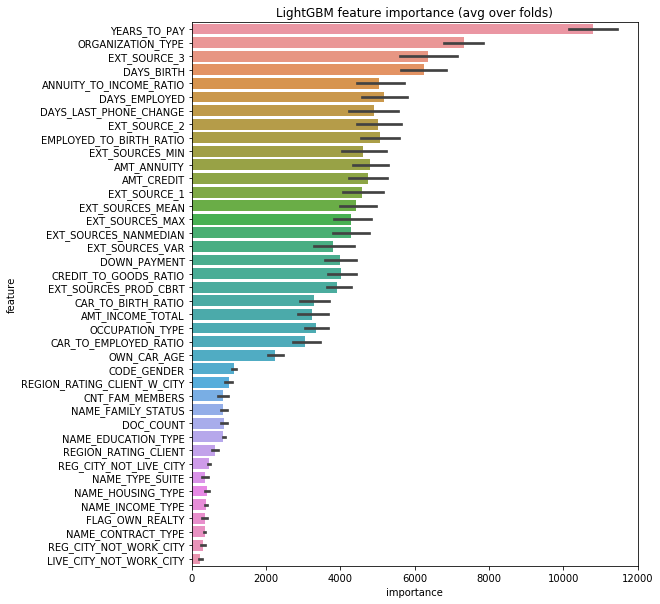

In [24]:
plot_feat_importance(feat_importance)

We get an AUC of about **0.767** using the new features. Next we will go through the *'bureau'* table to get more features

---
## Bureau table
In this part, we will explore the features provided by the 'bureau' table.

In [13]:
del application_train_proc
gc.collect()

0

In [14]:
bureau = pd.read_csv('./datasets/bureau.csv').rename(index=str, columns={'AMT_ANNUITY': 'AMT_ANNUITY_BUREAU'})

In [14]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_BUREAU
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [27]:
bureau['CREDIT_ACTIVE'].value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [28]:
bureau['CREDIT_CURRENCY'].value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64

In [87]:
bureau['CREDIT_TYPE'].value_counts()

Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile operator loan                                  1
Interbank credit                                      1
Name: CREDIT_TYPE, dtype: int64

### Feature engineering 
We will use various aggregation to come up with new features from the 'bureau' table

In [15]:
application_train_bureau = pd.merge(application_train, bureau, on='SK_ID_CURR', how='left')
del bureau
gc.collect()

7

In [30]:
application_train_bureau.groupby('SK_ID_CURR').head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_BUREAU
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,6158904.0,Closed,currency 1,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.000,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-11

#### Previous bureau credit applications Count
Count of all previous bureau credit applications

In [16]:
prev_buro_app_df = application_train_bureau.groupby(['SK_ID_CURR'])['SK_ID_BUREAU'].agg('count').reset_index(name='PREV_APP_CNT')
prev_buro_app_df.head()

,SK_ID_CURR,PREV_APP_CNT
0,100002,8
1,100003,4
2,100004,2
3,100006,0
4,100007,1


In [17]:
application_train_bureau = pd.merge(application_train_bureau, prev_buro_app_df, on='SK_ID_CURR', how='left')

In [18]:
del prev_buro_app_df
gc.collect()

35

#### Bad Debt Count
Count of all bad debts

In [19]:
bad_debt_df = application_train_bureau[application_train_bureau.CREDIT_ACTIVE=='Bad debt'].groupby(['SK_ID_CURR'])['CREDIT_ACTIVE'].agg('count').reset_index(name='BAD_DEBT_CNT')
bad_debt_df.head()

,SK_ID_CURR,BAD_DEBT_CNT
0,158069,1
1,163442,1
2,176952,1
3,186360,1
4,207535,1


In [20]:
application_train_bureau = pd.merge(application_train_bureau, bad_debt_df, on='SK_ID_CURR', how='left')

In [21]:
del bad_debt_df
gc.collect()

35

#### Closed Credit Count
Count of all credit that is closed

In [22]:
closed_credit_df = application_train_bureau[application_train_bureau.CREDIT_ACTIVE=='Closed'].groupby(['SK_ID_CURR']).size().reset_index(name='CLOSED_CREDIT_CNT')
closed_credit_df.head()

,SK_ID_CURR,CLOSED_CREDIT_CNT
0,100002,6
1,100003,3
2,100004,2
3,100007,1
4,100008,2


In [23]:
application_train_bureau = pd.merge(application_train_bureau, closed_credit_df, on='SK_ID_CURR', how='left')

In [24]:
del closed_credit_df
gc.collect()

35

#### Active debt count
Count of all the active debts

In [25]:
active_credit_df = application_train_bureau[application_train_bureau.CREDIT_ACTIVE=='Active'].groupby(['SK_ID_CURR']).size().reset_index(name='ACTIVE_CREDIT_CNT')
active_credit_df.head()

,SK_ID_CURR,ACTIVE_CREDIT_CNT
0,100002,2
1,100003,1
2,100008,1
3,100009,4
4,100010,1


In [26]:
application_train_bureau = pd.merge(application_train_bureau, active_credit_df, on='SK_ID_CURR', how='left')

In [27]:
del active_credit_df
gc.collect()

35

#### Sold debt count
Count of all the sold debt

In [28]:
sold_credit_df = application_train_bureau[application_train_bureau.CREDIT_ACTIVE=='Sold'].groupby(['SK_ID_CURR']).size().reset_index(name='SOLD_CREDIT_CNT')
sold_credit_df.head()

,SK_ID_CURR,SOLD_CREDIT_CNT
0,100039,1
1,100162,1
2,100201,1
3,100266,1
4,100325,1


In [29]:
application_train_bureau = pd.merge(application_train_bureau, sold_credit_df, on='SK_ID_CURR', how='left')

In [30]:
del sold_credit_df
gc.collect()

35

#### Amount active annuity
Total amount of active credits annuity

In [31]:
amt_annuity_active_df = application_train_bureau[application_train_bureau.CREDIT_ACTIVE=='Active'].groupby(['SK_ID_CURR']).agg({'AMT_ANNUITY_BUREAU': np.sum}).reset_index().rename(columns={'AMT_ANNUITY_BUREAU': 'AMT_ANNUITY_BUREAU_ACTIVE'}, inplace=False)
amt_annuity_active_df.head()

,SK_ID_CURR,AMT_ANNUITY_BUREAU_ACTIVE
0,100002,0.0
1,100003,0.0
2,100008,0.0
3,100009,0.0
4,100010,0.0


In [32]:
application_train_bureau = pd.merge(application_train_bureau, amt_annuity_active_df, on='SK_ID_CURR', how='left')

In [33]:
del amt_annuity_active_df
gc.collect()

7

#### Currency type count
Count of the different types of currencies in which the credit has been taken

In [34]:
currency_cnt_df = application_train_bureau.groupby(['SK_ID_CURR']).agg({'CREDIT_CURRENCY': pd.Series.nunique}).reset_index().rename(columns={'CREDIT_CURRENCY': 'CURRENCY_CNT'}, inplace=False)
currency_cnt_df.head()

,SK_ID_CURR,CURRENCY_CNT
0,100002,1
1,100003,1
2,100004,1
3,100006,0
4,100007,1


In [35]:
application_train_bureau = pd.merge(application_train_bureau, currency_cnt_df, on='SK_ID_CURR', how='left')

In [36]:
del currency_cnt_df
gc.collect()

49

#### Most recent credit
Days since the last credit

In [37]:
days_most_recent_credit_df = application_train_bureau.groupby(['SK_ID_CURR']).agg({'DAYS_CREDIT':np.max}).reset_index().rename(columns={'DAYS_CREDIT': 'DAYS_MOST_RECENT_CREDIT'}, inplace=False)
days_most_recent_credit_df.head()

,SK_ID_CURR,DAYS_MOST_RECENT_CREDIT
0,100002,-103.0
1,100003,-606.0
2,100004,-408.0
3,100006,NaN
4,100007,-1149.0


In [38]:
application_train_bureau = pd.merge(application_train_bureau, days_most_recent_credit_df, on='SK_ID_CURR', how='left')

In [39]:
del days_most_recent_credit_df
gc.collect()

42

#### Credit Duration
Duration of each line of credit

In [40]:
application_train_bureau['CREDIT_DURATION'] = application_train_bureau['DAYS_CREDIT_ENDDATE']-application_train_bureau['DAYS_CREDIT']

#### Debt to credit
Amount of debt to credit

In [41]:
application_train_bureau['DEBT_CREDIT_PERCENTAGE'] = application_train_bureau['AMT_CREDIT_SUM'] / application_train_bureau['AMT_CREDIT_SUM_DEBT']
application_train_bureau['DEBT_CREDIT_DIFF'] = application_train_bureau['AMT_CREDIT_SUM'] - application_train_bureau['AMT_CREDIT_SUM_DEBT']

#### Credit to annuity ration
Ration of credit amount to annuity payments

In [42]:
application_train_bureau['CREDIT_TO_ANNUITY_RATIO'] = application_train_bureau['AMT_CREDIT_SUM'] / application_train_bureau['AMT_ANNUITY_BUREAU']

#### Credit Prolongations
Count of all times credit has been prolonged

In [43]:
credit_prolog_cnt_df = application_train_bureau.groupby(['SK_ID_CURR']).agg({'CNT_CREDIT_PROLONG':np.sum}).reset_index().rename(columns={'CNT_CREDIT_PROLONG': 'CREDIT_PROLONG_COUNT'}, inplace=False)
credit_prolog_cnt_df.head()

,SK_ID_CURR,CREDIT_PROLONG_COUNT
0,100002,0.0
1,100003,0.0
2,100004,0.0
3,100006,0.0
4,100007,0.0


In [44]:
application_train_bureau = pd.merge(application_train_bureau, credit_prolog_cnt_df, on='SK_ID_CURR', how='left')

In [45]:
del credit_prolog_cnt_df
gc.collect()

14

#### Aggregations
Aggregations of numeric columns using various funtions

In [66]:
application_train_bureau.fillna({'CLOSED_CREDIT_CNT': 0, 'BAD_DEBT_CNT':0, 'ACTIVE_CREDIT_CNT':0, 'SOLD_CREDIT_CNT':0, 'AMT_CREDIT_SUM_OVERDUE_MEAN': 0}, inplace=True)
application_train_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3798: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [47]:
cols_agg = {
        'DAYS_CREDIT': ['min', 'mean', 'std'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean', 'std'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'sum'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY_BUREAU': ['max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DURATION': ['min', 'max', 'mean', 'std','sum'],
        'DEBT_CREDIT_PERCENTAGE': ['min', 'max', 'mean', 'std'],
        'DEBT_CREDIT_DIFF': ['min', 'max', 'mean', 'std','sum'],
        'CREDIT_TO_ANNUITY_RATIO': ['min', 'max', 'mean', 'std','sum']
    }

In [176]:
def apply_agg(df_to_agg, cols_agg_funcs, group_by_col, prefix=''):
    new_feats = []
    for col, funcs in cols_agg_funcs.items():
        for f in funcs:
            if(prefix):
                col_name = ('{}_{}_{}').format(prefix,col,f.upper())
            else:
                col_name = ('{}_{}').format(col,f.upper())
            new_feats.append(col_name)
            _df = df_to_agg.groupby([group_by_col])[col].agg(f).reset_index(name=col_name)
            df_to_agg = pd.merge(df_to_agg, _df, on=group_by_col, how='left')
            del _df
            gc.collect()
    return df_to_agg, new_feats

In [ ]:
application_train_bureau, bureau_stat_agg_features = apply_agg(application_train_bureau, cols_agg, 'SK_ID_CURR')

### Adding previous features
Adding the features we developped in the previous sections

In [49]:
bureau_features = [
    'PREV_APP_CNT',
    'BAD_DEBT_CNT',
    'CLOSED_CREDIT_CNT',
    'ACTIVE_CREDIT_CNT', 
    'SOLD_CREDIT_CNT', 
    'AMT_ANNUITY_BUREAU_ACTIVE', 
    'CURRENCY_CNT', 
    'DAYS_MOST_RECENT_CREDIT', 
    'CREDIT_PROLONG_COUNT'
] + bureau_stat_agg_features
appl_train_bureau_proc = application_train_bureau[['SK_ID_CURR','TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE','OWN_CAR_AGE'] + categorical_features + bureau_features]

for col in categorical_features:
    appl_train_bureau_proc.loc[:,col], uniques = pd.factorize(application_train_bureau[col])

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [50]:
appl_train_bureau_proc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1509303 entries, 0 to 1509302
Data columns (total 81 columns):
SK_ID_CURR                      1509303 non-null int64
TARGET                          1509303 non-null int64
AMT_INCOME_TOTAL                1509303 non-null float64
AMT_CREDIT                      1509303 non-null float64
AMT_ANNUITY                     1509260 non-null float64
DAYS_BIRTH                      1509303 non-null int64
DAYS_EMPLOYED                   1244254 non-null float64
CNT_FAM_MEMBERS                 1509303 non-null float64
EXT_SOURCE_1                    699244 non-null float64
EXT_SOURCE_2                    1506886 non-null float64
EXT_SOURCE_3                    1421715 non-null float64
DAYS_LAST_PHONE_CHANGE          1509302 non-null float64
OWN_CAR_AGE                     544346 non-null float64
FLAG_OWN_CAR                    1509303 non-null int64
CODE_GENDER                     1509303 non-null int64
FLAG_OWN_REALTY                 1509303 non-

In [51]:
appl_train_bureau_proc.drop_duplicates(inplace=True)
appl_train_bureau_proc = appl_train_bureau_proc.sort_values(by=['SK_ID_CURR']).reset_index(drop=True)

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [52]:
appl_train_bureau_proc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307502 entries, 0 to 307501
Data columns (total 81 columns):
SK_ID_CURR                      307502 non-null int64
TARGET                          307502 non-null int64
AMT_INCOME_TOTAL                307502 non-null float64
AMT_CREDIT                      307502 non-null float64
AMT_ANNUITY                     307490 non-null float64
DAYS_BIRTH                      307502 non-null int64
DAYS_EMPLOYED                   252128 non-null float64
CNT_FAM_MEMBERS                 307502 non-null float64
EXT_SOURCE_1                    134128 non-null float64
EXT_SOURCE_2                    306842 non-null float64
EXT_SOURCE_3                    246540 non-null float64
DAYS_LAST_PHONE_CHANGE          307501 non-null float64
OWN_CAR_AGE                     104578 non-null float64
FLAG_OWN_CAR                    307502 non-null int64
CODE_GENDER                     307502 non-null int64
FLAG_OWN_REALTY                 307502 non-null int64
NAME_

In [53]:
appl_train_bureau_proc[bureau_features] = appl_train_bureau_proc[bureau_features].replace(to_replace=[np.inf,-np.inf,np.nan],value=0)

In [69]:
appl_train_bureau_proc.head()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OWN_CAR_AGE,FLAG_OWN_CAR,CODE_GENDER,FLAG_OWN_REALTY,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,PREV_APP_CNT,BAD_DEBT_CNT,CLOSED_CREDIT_CNT,ACTIVE_CREDIT_CNT,SOLD_CREDIT_CNT,AMT_ANNUITY_BUREAU_ACTIVE,CURRENCY_CNT,DAYS_MOST_RECENT_CREDIT,CREDIT_PROLONG_COUNT,DAYS_CREDIT_MIN,DAYS_CREDIT_MEAN,DAYS_CREDIT_STD,DAYS_CREDIT_ENDDATE_MIN,DAYS_CREDIT_ENDDATE_MAX,DAYS_CREDIT_ENDDATE_MEAN,DAYS_CREDIT_ENDDATE_STD,CREDIT_DAY_OVERDUE_MAX,CREDIT_DAY_OVERDUE_MEAN,CREDIT_DAY_OVERDUE_SUM,AMT_CREDIT_MAX_OVERDUE_MEAN,AMT_CREDIT_MAX_OVERDUE_SUM,AMT_CREDIT_SUM_MAX,AMT_CREDIT_SUM_MEAN,AMT_CREDIT_SUM_SUM,AMT_CREDIT_SUM_DEBT_MAX,AMT_CREDIT_SUM_DEBT_MEAN,AMT_CREDIT_SUM_DEBT_SUM,AMT_CREDIT_SUM_OVERDUE_MEAN,AMT_CREDIT_SUM_LIMIT_MEAN,AMT_CREDIT_SUM_LIMIT_SUM,AMT_ANNUITY_BUREAU_MAX,AMT_ANNUITY_BUREAU_MEAN,DAYS_CREDIT_UPDATE_MEAN,CREDIT_DURATION_MIN,CREDIT_DURATION_MAX,CREDIT_DURATION_MEAN,CREDIT_DURATION_STD,CREDIT_DURATION_SUM,DEBT_CREDIT_PERCENTAGE_MIN,DEBT_CREDIT_PERCENTAGE_MAX,DEBT_CREDIT_PERCENTAGE_MEAN,DEBT_CREDIT_PERCENTAGE_STD,DEBT_CREDIT_DIFF_MIN,DEBT_CREDIT_DIFF_MAX,DEBT_CREDIT_DIFF_MEAN,DEBT_CREDIT_DIFF_STD,DEBT_CREDIT_DIFF_SUM,CREDIT_TO_ANNUITY_RATIO_MIN,CREDIT_TO_ANNUITY_RATIO_MAX,CREDIT_TO_ANNUITY_RATIO_MEAN,CREDIT_TO_ANNUITY_RATIO_STD,CREDIT_TO_ANNUITY_RATIO_SUM,DOC_COUNT,EXT_SOURCES_PROD_CBRT,YEARS_TO_PAY,DOWN_PAYMENT,CREDIT_TO_GOODS_RATIO,ANNUITY_TO_INCOME_RATIO,EMPLOYED_TO_BIRTH_RATIO,CAR_TO_BIRTH_RATIO,CAR_TO_EMPLOYED_RATIO,EXT_SOURCES_MIN,EXT_SOURCES_MAX,EXT_SOURCES_MEAN,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_VAR
0,100002,1,202500.0,406597.5,24700.5,-9461,-637.0,1.0,0.083037,0.262949,0.139376,-1134.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0.0,6.0,2.0,0.0,0.0,1,-103.0,0.0,-1437.0,-874.00,431.451040,-1072.0,780.0,-349.0,767.490977,0.0,0.0,0.0,1681.029,8405.145,450000.0,108131.945625,865055.565,245781.0,49156.2,245781.0,0.0,7997.14125,31988.565,0.0,0.0,-499.875,87.0,1822.0,719.833333,655.674131,4319.0,1.830898,0.0,0.0,0.0,0.0,204219.0,98388.513,82354.585520,491942.565,0.0,0.0,0.0,0.0,0.0,1,0.144914,16.461104,-55597.5,1.158397,0.121978,0.067329,NaN,NaN,0.083037,0.262949,0.161787,0.139376,0.005646
1,100003,0,270000.0,1293502.5,35698.5,-16765,-1188.0,2.0,0.311267,0.622246,NaN,-828.0,NaN,0,1,1,0,1,1,1,1,0,1,1,0,0,0,1,1,4,0.0,3.0,1.0,0.0,0.0,1,-606.0,0.0,-2586.0,-1400.75,909.826128,-2434.0,1216.0,-544.5,1492.770467,0.0,0.0,0.0,0.000,0.000,810000.0,254350.125000,1017400.500,0.0,0.0,0.0,0.0,202500.00000,810000.000,0.0,0.0,-816.000,152.0,1822.0,856.250000,761.002135,3425.0,0.000000,0.0,0.0,0.0,22248.0,810000.0,254350.125,372269.465535,1017400.500,0.0,0.0,0.0,0.0,0.0,1,NaN,36.234085,-942502.5,3.685192,0.132217,0.070862,NaN,NaN,0.311267,0.622246,0.466757,0.466757,0.024177
2,100004,0,67500.0,135000.0,6750.0,-19046,-225.0,1.0,NaN,0.555912,0.729567,-815.0,26.0,1,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,2,0.0,2.0,0.0,0.0,0.0,1,-408.0,0.0,-1326.0,-867.00,649.124025,-595.0,-382.0,-488.5,150.613744,0.0,0.0,0.0,0.000,0.000,94537.8,94518.900000,189037.800,0.0,0.0,0.0,0.0,0.00000,0.000,0.0,0.0,-532.000,26.0,731.0,378.500000,498.510281,757.0,0.000000,0.0,0.0,0.0,94500.0,94537.8,94518.900,26.728636,189037.800,0.0,0.0,0.0,0.0,0.0,1,NaN,20.000000,216000.0,0.384615,0.100000,0.011814,-0.001365,-0.115556,0.555912,0.729567,0.642739,0.642739,0.007539
3,100006,0,135000.0,312682.5,29686.5,-19005,-3039.0,2.0,NaN,0.650442,NaN,-617.0,NaN,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.000,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.00000,0.000,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000,0.0,0.0,0.0,0.

In [55]:
docs = [cl for cl in application_train_bureau.columns if 'FLAG_DOCUMENT_' in cl]
appl_train_bureau_proc['DOC_COUNT'] = application_train_bureau[docs].replace(np.nan,0).sum(axis=1)
appl_train_bureau_proc['EXT_SOURCES_PROD_CBRT'] = (appl_train_bureau_proc['EXT_SOURCE_1']*appl_train_bureau_proc['EXT_SOURCE_2']*appl_train_bureau_proc['EXT_SOURCE_3'])**(1/3)    
appl_train_bureau_proc['YEARS_TO_PAY'] = appl_train_bureau_proc['AMT_CREDIT'] / appl_train_bureau_proc['AMT_ANNUITY']
appl_train_bureau_proc['DOWN_PAYMENT'] = application_train_bureau['AMT_GOODS_PRICE']-appl_train_bureau_proc['AMT_CREDIT']
appl_train_bureau_proc['CREDIT_TO_GOODS_RATIO'] = appl_train_bureau_proc['AMT_CREDIT']/application_train_bureau['AMT_GOODS_PRICE']
appl_train_bureau_proc['ANNUITY_TO_INCOME_RATIO'] = appl_train_bureau_proc['AMT_ANNUITY'] / appl_train_bureau_proc['AMT_INCOME_TOTAL']
appl_train_bureau_proc['EMPLOYED_TO_BIRTH_RATIO'] = appl_train_bureau_proc['DAYS_EMPLOYED'] / appl_train_bureau_proc['DAYS_BIRTH']
appl_train_bureau_proc['CAR_TO_BIRTH_RATIO'] = appl_train_bureau_proc['OWN_CAR_AGE'] / appl_train_bureau_proc['DAYS_BIRTH']
appl_train_bureau_proc['CAR_TO_EMPLOYED_RATIO'] = appl_train_bureau_proc['OWN_CAR_AGE'] / appl_train_bureau_proc['DAYS_EMPLOYED']
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    appl_train_bureau_proc[feature_name] = eval('np.{}'.format(function_name))(
        appl_train_bureau_proc[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

C:\Users\mbouqsimi\AppData\Roaming\Python\Python36\site-packages\numpy\lib\function_base.py:3250: RuntimeWarning:

All-NaN slice encountered



In [92]:
del application_train_bureau
gc.collect()

7

In [64]:
df_to_model = appl_train_bureau_proc.drop(['SK_ID_CURR'], axis=1, inplace=False)
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(df_to_model,categorical_features,100)
del df_to_model
gc.collect()

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.775565	training's binary_logloss: 0.24358	valid_1's auc: 0.755363	valid_1's binary_logloss: 0.24857
[800]	training's auc: 0.799889	training's binary_logloss: 0.234303	valid_1's auc: 0.766328	valid_1's binary_logloss: 0.244042
[1200]	training's auc: 0.817235	training's binary_logloss: 0.228171	valid_1's auc: 0.770351	valid_1's binary_logloss: 0.242533
[1600]	training's auc: 0.831978	training's binary_logloss: 0.223019	valid_1's auc: 0.772197	valid_1's binary_logloss: 0.241868
[2000]	training's auc: 0.845011	training's binary_logloss: 0.218454	valid_1's auc: 0.772773	valid_1's binary_logloss: 0.241622
[2400]	training's auc: 0.856457	training's binary_logloss: 0.214308	valid_1's auc: 0.773283	valid_1's binary_logloss: 0.241445
Early stopping, best iteration is:
[2596]	training's auc: 0.861718	training's binary_logloss: 0.212378	valid_1's auc: 0.773388	valid_1's binary_logloss: 0.241407
Training time: 16

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.776648	training's binary_logloss: 0.243175	valid_1's auc: 0.750696	valid_1's binary_logloss: 0.249943
[800]	training's auc: 0.800825	training's binary_logloss: 0.233881	valid_1's auc: 0.760888	valid_1's binary_logloss: 0.245804
[1200]	training's auc: 0.818292	training's binary_logloss: 0.227698	valid_1's auc: 0.765129	valid_1's binary_logloss: 0.24438
[1600]	training's auc: 0.832573	training's binary_logloss: 0.222651	valid_1's auc: 0.767044	valid_1's binary_logloss: 0.243789
[2000]	training's auc: 0.845287	training's binary_logloss: 0.218128	valid_1's auc: 0.768137	valid_1's binary_logloss: 0.243479
[2400]	training's auc: 0.856773	training's binary_logloss: 0.213991	valid_1's auc: 0.768627	valid_1's binary_logloss: 0.243346
Early stopping, best iteration is:
[2563]	training's auc: 0.861052	training's binary_logloss: 0.212378	valid_1's auc: 0.76882	valid_1's binary_logloss: 0.243289
Training time: 18

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.775047	training's binary_logloss: 0.243732	valid_1's auc: 0.756869	valid_1's binary_logloss: 0.24828
[800]	training's auc: 0.799225	training's binary_logloss: 0.234516	valid_1's auc: 0.76772	valid_1's binary_logloss: 0.243676
[1200]	training's auc: 0.816375	training's binary_logloss: 0.228437	valid_1's auc: 0.772355	valid_1's binary_logloss: 0.242005
[1600]	training's auc: 0.830794	training's binary_logloss: 0.223425	valid_1's auc: 0.774519	valid_1's binary_logloss: 0.241264
[2000]	training's auc: 0.84348	training's binary_logloss: 0.21895	valid_1's auc: 0.775735	valid_1's binary_logloss: 0.240834
[2400]	training's auc: 0.855187	training's binary_logloss: 0.214816	valid_1's auc: 0.776562	valid_1's binary_logloss: 0.240553
Early stopping, best iteration is:
[2695]	training's auc: 0.863089	training's binary_logloss: 0.21191	valid_1's auc: 0.776955	valid_1's binary_logloss: 0.24042
Training time: 192.30

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.774976	training's binary_logloss: 0.243891	valid_1's auc: 0.758223	valid_1's binary_logloss: 0.24784
[800]	training's auc: 0.799243	training's binary_logloss: 0.234619	valid_1's auc: 0.769407	valid_1's binary_logloss: 0.242954
[1200]	training's auc: 0.816419	training's binary_logloss: 0.228504	valid_1's auc: 0.773992	valid_1's binary_logloss: 0.241209
[1600]	training's auc: 0.830907	training's binary_logloss: 0.223481	valid_1's auc: 0.776227	valid_1's binary_logloss: 0.240417
[2000]	training's auc: 0.843836	training's binary_logloss: 0.219006	valid_1's auc: 0.777367	valid_1's binary_logloss: 0.240046
[2400]	training's auc: 0.855438	training's binary_logloss: 0.214868	valid_1's auc: 0.778041	valid_1's binary_logloss: 0.239802
[2800]	training's auc: 0.865887	training's binary_logloss: 0.211002	valid_1's auc: 0.778661	valid_1's binary_logloss: 0.23962
[3200]	training's auc: 0.875369	training's binary_lo

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's auc: 0.776068	training's binary_logloss: 0.243273	valid_1's auc: 0.751242	valid_1's binary_logloss: 0.249485
[800]	training's auc: 0.800047	training's binary_logloss: 0.234093	valid_1's auc: 0.762774	valid_1's binary_logloss: 0.245196
[1200]	training's auc: 0.81739	training's binary_logloss: 0.227958	valid_1's auc: 0.767821	valid_1's binary_logloss: 0.243545
[1600]	training's auc: 0.832109	training's binary_logloss: 0.222874	valid_1's auc: 0.770321	valid_1's binary_logloss: 0.242764
[2000]	training's auc: 0.845246	training's binary_logloss: 0.218291	valid_1's auc: 0.771695	valid_1's binary_logloss: 0.242313
[2400]	training's auc: 0.856906	training's binary_logloss: 0.214085	valid_1's auc: 0.772568	valid_1's binary_logloss: 0.242057
[2800]	training's auc: 0.867188	training's binary_logloss: 0.210212	valid_1's auc: 0.773214	valid_1's binary_logloss: 0.241859
Early stopping, best iteration is:
[3045]	training'

14

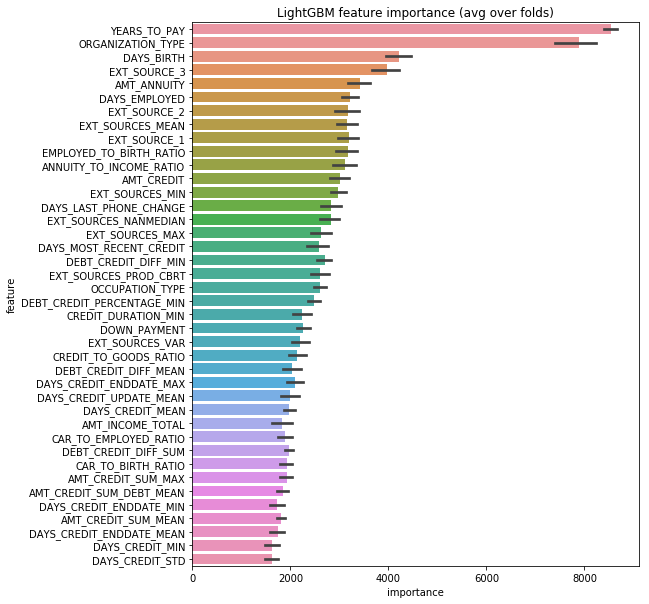

In [64]:
plot_feat_importance(feat_importance)

We get an AUC of about **0.774** using the bureau data. Next we will go through the *'previous_application'* table to get more features

---
## Previous_application table
In this part, we will explore the features provided by the 'previous_application' table.

In [56]:
previous_application = pd.read_csv('./datasets/previous_application.csv').rename(index=str, columns={'NAME_CONTRACT_TYPE': 'NAME_CONTRACT_TYPE_PREV', 'AMT_ANNUITY': 'AMT_ANNUITY_PREV', 'AMT_CREDIT': 'AMT_CREDIT_PREV', 'AMT_GOODS_PRICE': 'AMT_GOODS_PRICE_PREV', 'AMT_DOWN_PAYMENT': 'AMT_DOWN_PAYMENT_PREV'})

In [57]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE_PREV,AMT_ANNUITY_PREV,AMT_APPLICATION,AMT_CREDIT_PREV,AMT_DOWN_PAYMENT_PREV,AMT_GOODS_PRICE_PREV,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
previous_application.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
SK_ID_PREV                     1670214 non-null int64
SK_ID_CURR                     1670214 non-null int64
NAME_CONTRACT_TYPE_PREV        1670214 non-null object
AMT_ANNUITY_PREV               1297979 non-null float64
AMT_APPLICATION                1670214 non-null float64
AMT_CREDIT_PREV                1670213 non-null float64
AMT_DOWN_PAYMENT_PREV          774370 non-null float64
AMT_GOODS_PRICE_PREV           1284699 non-null float64
WEEKDAY_APPR_PROCESS_START     1670214 non-null object
HOUR_APPR_PROCESS_START        1670214 non-null int64
FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null object
NFLAG_LAST_APPL_IN_DAY         1670214 non-null int64
RATE_DOWN_PAYMENT              774370 non-null float64
RATE_INTEREST_PRIMARY          5951 non-null float64
RATE_INTEREST_PRIVILEGED       5951 non-null float64
NAME_CASH_LOAN_PURPOSE         1670214 non-null object
NAME_CONTRACT_ST

In [71]:
previous_application.select_dtypes(include=['object']).columns

Index(['NAME_CONTRACT_TYPE_PREV', 'WEEKDAY_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION'],
      dtype='object')

In [72]:
previous_application['NAME_CONTRACT_TYPE_PREV'].value_counts()

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE_PREV, dtype: int64

In [75]:
previous_application['FLAG_LAST_APPL_PER_CONTRACT'].value_counts()

Y    1661739
N       8475
Name: FLAG_LAST_APPL_PER_CONTRACT, dtype: int64

In [76]:
previous_application['NAME_CASH_LOAN_PURPOSE'].value_counts()

XAP                                 922661
XNA                                 677918
Repairs                              23765
Other                                15608
Urgent needs                          8412
Buying a used car                     2888
Building a house or an annex          2693
Everyday expenses                     2416
Medicine                              2174
Payments on other loans               1931
Education                             1573
Journey                               1239
Purchase of electronic equipment      1061
Buying a new car                      1012
Wedding / gift / holiday               962
Buying a home                          865
Car repairs                            797
Furniture                              749
Buying a holiday home / land           533
Business development                   426
Gasification / water supply            300
Buying a garage                        136
Hobby                                   55
Money for a

In [77]:
previous_application['NAME_CONTRACT_STATUS'].value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: NAME_CONTRACT_STATUS, dtype: int64

In [78]:
previous_application['NAME_PAYMENT_TYPE'].value_counts()

Cash through the bank                        1033552
XNA                                           627384
Non-cash from your account                      8193
Cashless from the account of the employer       1085
Name: NAME_PAYMENT_TYPE, dtype: int64

In [79]:
previous_application['CODE_REJECT_REASON'].value_counts()

XAP       1353093
HC         175231
LIMIT       55680
SCO         37467
CLIENT      26436
SCOFR       12811
XNA          5244
VERIF        3535
SYSTEM        717
Name: CODE_REJECT_REASON, dtype: int64

In [80]:
previous_application['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      508970
Family             213263
Spouse, partner     67069
Children            31566
Other_B             17624
Other_A              9077
Group of people      2240
Name: NAME_TYPE_SUITE, dtype: int64

In [81]:
previous_application['NAME_CLIENT_TYPE'].value_counts()

Repeater     1231261
New           301363
Refreshed     135649
XNA             1941
Name: NAME_CLIENT_TYPE, dtype: int64

In [83]:
previous_application['NAME_GOODS_CATEGORY'].value_counts()

XNA                         950809
Mobile                      224708
Consumer Electronics        121576
Computers                   105769
Audio/Video                  99441
Furniture                    53656
Photo / Cinema Equipment     25021
Construction Materials       24995
Clothing and Accessories     23554
Auto Accessories              7381
Jewelry                       6290
Homewares                     5023
Medical Supplies              3843
Vehicles                      3370
Sport and Leisure             2981
Gardening                     2668
Other                         2554
Office Appliances             2333
Tourism                       1659
Medicine                      1550
Direct Sales                   446
Fitness                        209
Additional Service             128
Education                      107
Weapon                          77
Insurance                       64
Animals                          1
House Construction               1
Name: NAME_GOODS_CAT

In [82]:
previous_application['NAME_PORTFOLIO'].value_counts()

POS      691011
Cash     461563
XNA      372230
Cards    144985
Cars        425
Name: NAME_PORTFOLIO, dtype: int64

In [84]:
previous_application['NAME_PRODUCT_TYPE'].value_counts()

XNA        1063666
x-sell      456287
walk-in     150261
Name: NAME_PRODUCT_TYPE, dtype: int64

In [85]:
previous_application['CHANNEL_TYPE'].value_counts()

Credit and cash offices       719968
Country-wide                  494690
Stone                         212083
Regional / Local              108528
Contact center                 71297
AP+ (Cash loan)                57046
Channel of corporate sales      6150
Car dealer                       452
Name: CHANNEL_TYPE, dtype: int64

In [86]:
previous_application['NAME_SELLER_INDUSTRY'].value_counts()

XNA                     855720
Consumer electronics    398265
Connectivity            276029
Furniture                57849
Construction             29781
Clothing                 23949
Industry                 19194
Auto technology           4990
Jewelry                   2709
MLM partners              1215
Tourism                    513
Name: NAME_SELLER_INDUSTRY, dtype: int64

In [87]:
previous_application['NAME_YIELD_GROUP'].value_counts()

XNA           517215
middle        385532
high          353331
low_normal    322095
low_action     92041
Name: NAME_YIELD_GROUP, dtype: int64

In [88]:
previous_application['PRODUCT_COMBINATION'].value_counts()

Cash                              285990
POS household with interest       263622
POS mobile with interest          220670
Cash X-Sell: middle               143883
Cash X-Sell: low                  130248
Card Street                       112582
POS industry with interest         98833
POS household without interest     82908
Card X-Sell                        80582
Cash Street: high                  59639
Cash X-Sell: high                  59301
Cash Street: middle                34658
Cash Street: low                   33834
POS mobile without interest        24082
POS other with interest            23879
POS industry without interest      12602
POS others without interest         2555
Name: PRODUCT_COMBINATION, dtype: int64

In [59]:
# Replacing the 1000 years values since they are clearly meant to represent a null value
previous_application.replace(365243, np.nan, inplace= True) 

In [60]:
previous_application['ASK_GRANTED_RATIO'] = previous_application['AMT_APPLICATION']/previous_application['AMT_CREDIT_PREV']
previous_application['ASK_GRANTED_DIFF'] = previous_application['AMT_APPLICATION']-previous_application['AMT_CREDIT_PREV']
previous_application['YEARS_TO_PAY'] = previous_application['AMT_ANNUITY_PREV']/previous_application['AMT_CREDIT_PREV']
previous_application['CREDIT_TO_GOODS_RATIO_PREV'] = previous_application['AMT_CREDIT_PREV']/previous_application['AMT_GOODS_PRICE_PREV']

In [93]:
prev_apprv_df = previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Approved'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_PREV_APPROUVED')
prev_apprv_df.head()

,SK_ID_CURR,CNT_PREV_APPROUVED
0,100001.0,1
1,100002.0,1
2,100003.0,3
3,100004.0,1
4,100005.0,1


In [94]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_apprv_df, on='SK_ID_CURR', how='left')

In [95]:
del prev_apprv_df
gc.collect()

35

In [96]:
prev_ref_df = previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Refused'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_PREV_REFUSED')
prev_ref_df.head()

,SK_ID_CURR,CNT_PREV_REFUSED
0,100006.0,1
1,100011.0,1
2,100027.0,1
3,100030.0,10
4,100035.0,8


In [97]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_ref_df, on='SK_ID_CURR', how='left')

In [98]:
del prev_ref_df
gc.collect()

35

In [99]:
prev_cancel_df = previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Canceled'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_PREV_CANCELED')
prev_cancel_df.head()

,SK_ID_CURR,CNT_PREV_CANCELED
0,100005.0,1
1,100006.0,3
2,100008.0,1
3,100012.0,1
4,100013.0,1


In [100]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_cancel_df, on='SK_ID_CURR', how='left')

In [101]:
del prev_cancel_df
gc.collect()

35

In [102]:
prev_unused_df = previous_application[previous_application['NAME_CONTRACT_STATUS'] == 'Unused offer'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].agg('count').reset_index(name='CNT_PREV_UNUSED')
prev_unused_df.head()

,SK_ID_CURR,CNT_PREV_UNUSED
0,100028.0,1
1,100057.0,1
2,100061.0,1
3,100086.0,1
4,100092.0,1


In [103]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_unused_df, on='SK_ID_CURR', how='left')

In [104]:
del prev_unused_df
gc.collect()

35

In [105]:
prev_cash_df = previous_application[previous_application['NAME_PORTFOLIO'] == 'Cash'].groupby(['SK_ID_CURR'])['NAME_PORTFOLIO'].agg('count').reset_index(name='CNT_PREV_CASH_PORTFOLIO')
prev_cash_df.head()

,SK_ID_CURR,CNT_PREV_CASH_PORTFOLIO
0,100003.0,1
1,100006.0,3
2,100007.0,4
3,100008.0,1
4,100011.0,1


In [106]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_cash_df, on='SK_ID_CURR', how='left')

In [107]:
del prev_cash_df
gc.collect()

35

In [116]:
prev_pos_df = previous_application[previous_application['NAME_PORTFOLIO'] == 'POS'].groupby(['SK_ID_CURR'])['NAME_PORTFOLIO'].agg('count').reset_index(name='CNT_PREV_POS_PORTFOLIO')
prev_pos_df.head()

,SK_ID_CURR,CNT_PREV_POS_PORTFOLIO
0,100001.0,1
1,100002.0,1
2,100003.0,2
3,100004.0,1
4,100005.0,1


In [117]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_pos_df, on='SK_ID_CURR', how='left')

In [118]:
del prev_pos_df
gc.collect()

120

In [122]:
prev_cash_df = previous_application[previous_application['NAME_PORTFOLIO'] == 'Cash'].groupby(['SK_ID_CURR'])['NAME_PORTFOLIO'].agg('count').reset_index(name='CNT_PREV_CASH_PORTFOLIO')
prev_cash_df.head()

,SK_ID_CURR,CNT_PREV_CASH_PORTFOLIO
0,100003.0,1
1,100006.0,3
2,100007.0,4
3,100008.0,1
4,100011.0,1


In [123]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_cash_df, on='SK_ID_CURR', how='left')

In [124]:
del prev_cash_df
gc.collect()

28

In [126]:
prev_cards_df = previous_application[previous_application['NAME_PORTFOLIO'] == 'Cards'].groupby(['SK_ID_CURR'])['NAME_PORTFOLIO'].agg('count').reset_index(name='CNT_PREV_CARDS_PORTFOLIO')
prev_cards_df.head()

,SK_ID_CURR,CNT_PREV_CARDS_PORTFOLIO
0,100006.0,1
1,100011.0,1
2,100021.0,1
3,100023.0,1
4,100028.0,1


In [127]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_cards_df, on='SK_ID_CURR', how='left')

In [128]:
del prev_cards_df
gc.collect()

28

In [129]:
prev_cash_loan_df = previous_application[previous_application['NAME_CONTRACT_TYPE_PREV'] == 'Cash loans'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_TYPE_PREV'].agg('count').reset_index(name='CNT_PREV_CASH_LOANS')
prev_cash_loan_df.head()

,SK_ID_CURR,CNT_PREV_CASH_LOANS
0,100003.0,1
1,100005.0,1
2,100006.0,5
3,100007.0,4
4,100008.0,2


In [130]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_cash_loan_df, on='SK_ID_CURR', how='left')

In [131]:
del prev_cash_loan_df
gc.collect()

35

In [133]:
prev_cons_loan_df = previous_application[previous_application['NAME_CONTRACT_TYPE_PREV'] == 'Consumer loans'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_TYPE_PREV'].agg('count').reset_index(name='CNT_PREV_CONSUMER_LOANS')
prev_cons_loan_df.head()

,SK_ID_CURR,CNT_PREV_CONSUMER_LOANS
0,100001.0,1
1,100002.0,1
2,100003.0,2
3,100004.0,1
4,100005.0,1


In [134]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_cons_loan_df, on='SK_ID_CURR', how='left')

In [135]:
del prev_cons_loan_df
gc.collect()

0

In [141]:
prev_rev_loan_df = previous_application[previous_application['NAME_CONTRACT_TYPE_PREV'] == 'Revolving loans'].groupby(['SK_ID_CURR'])['NAME_CONTRACT_TYPE_PREV'].agg('count').reset_index(name='CNT_PREV_REVOLV_LOANS')
prev_rev_loan_df.head()

,SK_ID_CURR,CNT_PREV_REVOLV_LOANS
0,100006.0,2
1,100011.0,1
2,100021.0,1
3,100023.0,1
4,100028.0,1


In [142]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_rev_loan_df, on='SK_ID_CURR', how='left')

In [143]:
del prev_rev_loan_df
gc.collect()

86

In [145]:
prev_xna_yield_df = previous_application[previous_application['NAME_YIELD_GROUP'] == 'XNA'].groupby(['SK_ID_CURR'])['NAME_YIELD_GROUP'].agg('count').reset_index(name='CNT_PREV_XNA_YIELD')
prev_xna_yield_df.head()

,SK_ID_CURR,CNT_PREV_XNA_YIELD
0,100005.0,1
1,100006.0,4
2,100008.0,1
3,100011.0,2
4,100012.0,1


In [146]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_xna_yield_df, on='SK_ID_CURR', how='left')

In [147]:
del prev_xna_yield_df
gc.collect()

28

In [148]:
prev_middle_yield_df = previous_application[previous_application['NAME_YIELD_GROUP'] == 'middle'].groupby(['SK_ID_CURR'])['NAME_YIELD_GROUP'].agg('count').reset_index(name='CNT_PREV_MIDDLE_YIELD')
prev_middle_yield_df.head()

,SK_ID_CURR,CNT_PREV_MIDDLE_YIELD
0,100003.0,2
1,100004.0,1
2,100006.0,1
3,100007.0,3
4,100008.0,1


In [149]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_middle_yield_df, on='SK_ID_CURR', how='left')

In [150]:
del prev_middle_yield_df
gc.collect()

35

In [151]:
prev_high_yield_df = previous_application[previous_application['NAME_YIELD_GROUP'] == 'high'].groupby(['SK_ID_CURR'])['NAME_YIELD_GROUP'].agg('count').reset_index(name='CNT_PREV_HIGH_YIELD')
prev_high_yield_df.head()

,SK_ID_CURR,CNT_PREV_HIGH_YIELD
0,100001.0,1
1,100005.0,1
2,100006.0,2
3,100007.0,3
4,100009.0,2


In [152]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_high_yield_df, on='SK_ID_CURR', how='left')

In [153]:
del prev_high_yield_df
gc.collect()

35

In [155]:
prev_low_normal_df = previous_application[previous_application['NAME_YIELD_GROUP'] == 'low_normal'].groupby(['SK_ID_CURR'])['NAME_YIELD_GROUP'].agg('count').reset_index(name='CNT_PREV_LOW_NORMAL_YIELD')
prev_low_normal_df.head()

,SK_ID_CURR,CNT_PREV_LOW_NORMAL_YIELD
0,100002.0,1
1,100003.0,1
2,100006.0,2
3,100008.0,3
4,100009.0,1


In [156]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_low_normal_df, on='SK_ID_CURR', how='left')

In [157]:
del prev_low_normal_df
gc.collect()

28

In [158]:
prev_low_action_df = previous_application[previous_application['NAME_YIELD_GROUP'] == 'low_action'].groupby(['SK_ID_CURR'])['NAME_YIELD_GROUP'].agg('count').reset_index(name='CNT_PREV_LOW_ACTION_YIELD')
prev_low_action_df.head()

,SK_ID_CURR,CNT_PREV_LOW_ACTION_YIELD
0,100009.0,1
1,100010.0,1
2,100011.0,1
3,100014.0,1
4,100028.0,1


In [159]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_low_action_df, on='SK_ID_CURR', how='left')

In [160]:
del prev_low_action_df
gc.collect()

35

In [162]:
prev_cl_type_refresh_df = previous_application[previous_application['NAME_CLIENT_TYPE'] == 'Refreshed'].groupby(['SK_ID_CURR'])['NAME_CLIENT_TYPE'].agg('count').reset_index(name='CNT_PREV_CLIENT_TYPE_REFRESHED')
prev_cl_type_refresh_df.head()

,SK_ID_CURR,CNT_PREV_CLIENT_TYPE_REFRESHED
0,100001.0,1
1,100003.0,2
2,100008.0,1
3,100009.0,1
4,100017.0,1


In [164]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, prev_cl_type_refresh_df, on='SK_ID_CURR', how='left')

In [165]:
del prev_cl_type_refresh_df
gc.collect()

143

In [177]:
prev_cols_agg = {
    'AMT_ANNUITY_PREV': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean', 'sum'],
    'AMT_CREDIT_PREV': ['min', 'max', 'mean', 'sum'],
    'AMT_DOWN_PAYMENT_PREV': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE_PREV': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean'],      
    'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'SELLERPLACE_AREA': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_FIRST_DRAWING': ['min', 'max', 'mean'],
    'DAYS_FIRST_DUE': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
    'DAYS_LAST_DUE': ['min', 'max', 'mean'],
    'DAYS_TERMINATION': ['min', 'max', 'mean'],
    'NFLAG_INSURED_ON_APPROVAL': ['mean', 'std'],
    'ASK_GRANTED_RATIO': ['min', 'max', 'mean', 'std'],
    'ASK_GRANTED_DIFF': ['min', 'max', 'mean', 'std'],
    'YEARS_TO_PAY': ['min', 'max', 'mean', 'std', 'sum'],
    'CREDIT_TO_GOODS_RATIO_PREV': ['min', 'max', 'mean', 'std']
}

In [178]:
previous_application, prev_stat_features = apply_agg(previous_application, prev_cols_agg, 'SK_ID_CURR', 'PREV')

In [182]:
appl_train_bureau_proc = pd.merge(appl_train_bureau_proc, previous_application[['SK_ID_CURR']+prev_stat_features], on='SK_ID_CURR', how='left')

In [183]:
appl_train_bureau_proc.drop_duplicates(inplace=True)
appl_train_bureau_proc = appl_train_bureau_proc.sort_values(by=['SK_ID_CURR']).reset_index(drop=True)

In [185]:
appl_train_bureau_proc.fillna({
    'CNT_PREV_APPROUVED': 0,
    'CNT_PREV_REFUSED': 0,
    'CNT_PREV_CANCELED': 0,
    'CNT_PREV_UNUSED': 0,
    'CNT_PREV_POS_PORTFOLIO': 0,
    'CNT_PREV_CASH_PORTFOLIO': 0,
    'CNT_PREV_CARDS_PORTFOLIO': 0,
    'CNT_PREV_CASH_LOANS': 0,
    'CNT_PREV_CONSUMER_LOANS': 0,
    'CNT_PREV_REVOLV_LOANS': 0,
    'CNT_PREV_XNA_YIELD': 0,
    'CNT_PREV_MIDDLE_YIELD': 0,
    'CNT_PREV_HIGH_YIELD': 0,
    'CNT_PREV_LOW_NORMAL_YIELD': 0,
    'CNT_PREV_LOW_ACTION_YIELD': 0,
    'CNT_PREV_CLIENT_TYPE_REFRESHED': 0}, inplace=True)
appl_train_bureau_proc.replace([np.inf, -np.inf], np.nan, inplace=True)

In [186]:
del previous_application
gc.collect()

14

In [ ]:
df_to_model = appl_train_bureau_proc.drop(['SK_ID_CURR'], axis=1, inplace=False)
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(df_to_model,categorical_features,100)
del df_to_model
gc.collect()

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.241223	training's auc: 0.786355	valid_1's binary_logloss: 0.247359	valid_1's auc: 0.760163
[800]	training's binary_logloss: 0.230212	training's auc: 0.813359	valid_1's binary_logloss: 0.242204	valid_1's auc: 0.771957
[1200]	training's binary_logloss: 0.222874	training's auc: 0.832111	valid_1's binary_logloss: 0.240414	valid_1's auc: 0.776447
[1600]	training's binary_logloss: 0.216799	training's auc: 0.84793	valid_1's binary_logloss: 0.239572	valid_1's auc: 0.778574
[2000]	training's binary_logloss: 0.211358	training's auc: 0.862035	valid_1's binary_logloss: 0.239105	valid_1's auc: 0.779863
[2400]	training's binary_logloss: 0.206386	training's auc: 0.874646	valid_1's binary_logloss: 0.238883	valid_1's auc: 0.780524
[2800]	training's binary_logloss: 0.201783	training's auc: 0.885798	valid_1's binary_logloss: 0.238687	valid_1's auc: 0.78105
[3200]	training's binary_logloss: 0.197415	training'

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.240908	training's auc: 0.786387	valid_1's binary_logloss: 0.248539	valid_1's auc: 0.757251
[800]	training's binary_logloss: 0.229941	training's auc: 0.81341	valid_1's binary_logloss: 0.243448	valid_1's auc: 0.769733
[1200]	training's binary_logloss: 0.222561	training's auc: 0.832383	valid_1's binary_logloss: 0.241607	valid_1's auc: 0.774524
[1600]	training's binary_logloss: 0.216425	training's auc: 0.848314	valid_1's binary_logloss: 0.240705	valid_1's auc: 0.777028
[2000]	training's binary_logloss: 0.211013	training's auc: 0.862095	valid_1's binary_logloss: 0.240209	valid_1's auc: 0.778436
[2400]	training's binary_logloss: 0.20607	training's auc: 0.874481	valid_1's binary_logloss: 0.239911	valid_1's auc: 0.779324
[2800]	training's binary_logloss: 0.20149	training's auc: 0.885623	valid_1's binary_logloss: 0.239712	valid_1's auc: 0.779895
[3200]	training's binary_logloss: 0.197192	training's

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.241365	training's auc: 0.785358	valid_1's binary_logloss: 0.246931	valid_1's auc: 0.76406
[800]	training's binary_logloss: 0.230582	training's auc: 0.81184	valid_1's binary_logloss: 0.24139	valid_1's auc: 0.776861
[1200]	training's binary_logloss: 0.223334	training's auc: 0.830603	valid_1's binary_logloss: 0.239305	valid_1's auc: 0.781945
[1600]	training's binary_logloss: 0.217255	training's auc: 0.846617	valid_1's binary_logloss: 0.238206	valid_1's auc: 0.784744
[2000]	training's binary_logloss: 0.211847	training's auc: 0.860747	valid_1's binary_logloss: 0.23763	valid_1's auc: 0.786212
[2400]	training's binary_logloss: 0.206901	training's auc: 0.873433	valid_1's binary_logloss: 0.237248	valid_1's auc: 0.787193
[2800]	training's binary_logloss: 0.202308	training's auc: 0.884876	valid_1's binary_logloss: 0.23695	valid_1's auc: 0.788038
[3200]	training's binary_logloss: 0.197988	training's a

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.241548	training's auc: 0.785268	valid_1's binary_logloss: 0.246459	valid_1's auc: 0.765183
[800]	training's binary_logloss: 0.230675	training's auc: 0.812244	valid_1's binary_logloss: 0.2409	valid_1's auc: 0.777401
[1200]	training's binary_logloss: 0.223358	training's auc: 0.830983	valid_1's binary_logloss: 0.238755	valid_1's auc: 0.782507
[1600]	training's binary_logloss: 0.217251	training's auc: 0.846845	valid_1's binary_logloss: 0.237755	valid_1's auc: 0.784971
[2000]	training's binary_logloss: 0.211808	training's auc: 0.861053	valid_1's binary_logloss: 0.237122	valid_1's auc: 0.786641
[2400]	training's binary_logloss: 0.206877	training's auc: 0.873579	valid_1's binary_logloss: 0.236824	valid_1's auc: 0.787415
[2800]	training's binary_logloss: 0.202289	training's auc: 0.884796	valid_1's binary_logloss: 0.236662	valid_1's auc: 0.787829
[3200]	training's binary_logloss: 0.197993	training'

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.240876	training's auc: 0.78655	valid_1's binary_logloss: 0.248507	valid_1's auc: 0.756095
[800]	training's binary_logloss: 0.230045	training's auc: 0.81311	valid_1's binary_logloss: 0.243464	valid_1's auc: 0.769104
[1200]	training's binary_logloss: 0.222738	training's auc: 0.83198	valid_1's binary_logloss: 0.241522	valid_1's auc: 0.774597
[1600]	training's binary_logloss: 0.216622	training's auc: 0.848042	valid_1's binary_logloss: 0.240505	valid_1's auc: 0.777668
[2000]	training's binary_logloss: 0.211156	training's auc: 0.862249	valid_1's binary_logloss: 0.239875	valid_1's auc: 0.779632
[2400]	training's binary_logloss: 0.206165	training's auc: 0.874964	valid_1's binary_logloss: 0.239546	valid_1's auc: 0.780613
[2800]	training's binary_logloss: 0.201572	training's auc: 0.886121	valid_1's binary_logloss: 0.239336	valid_1's auc: 0.781227
[3200]	training's binary_logloss: 0.197229	training's

In [ ]:
plot_feat_importance(feat_importance)

In [ ]:
plot_roc_auc(fprs[2], tprs[2],roc_aucs[2])

In [188]:
appl_train_bureau_proc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307502 entries, 0 to 307501
Columns: 180 entries, SK_ID_CURR to PREV_CREDIT_TO_GOODS_RATIO_PREV_STD
dtypes: float64(158), int64(22)
memory usage: 422.3 MB


In [175]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE_PREV,AMT_ANNUITY_PREV,AMT_APPLICATION,AMT_CREDIT_PREV,AMT_DOWN_PAYMENT_PREV,AMT_GOODS_PRICE_PREV,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,ASK_GRANTED_RATIO,ASK_GRANTED_DIFF,YEARS_TO_PAY,CREDIT_TO_GOODS_RATIO_PREV
0,2030495,271877.0,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,NaN,-42.0,300.0,-42.0,-37.0,0.0,1.000000,0.0,0.100929,1.00000
1,2802425,108129.0,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,NaN,-134.0,916.0,NaN,NaN,1.0,0.893815,-72171.0,0.037060,1.11880
2,2523466,122040.0,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,NaN,-271.0,59.0,NaN,NaN,1.0,0.824511,-23944.5,0.110380,1.21284
3,2819243,176158.0,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,NaN,-482.0,-152.0,-182.0,-177.0,1.0,0.955840,-20790.0,0.099920,1.04620
4,1784265,202054.0,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN,0.835282,-66555.0,0.079010,1.19720


In [74]:
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(appl_train_bureau_proc,categorical_features+['AGE_BIN'],150)

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 150 rounds.
[400]	training's binary_logloss: 0.243493	training's auc: 0.775875	valid_1's binary_logloss: 0.248544	valid_1's auc: 0.75541
[800]	training's binary_logloss: 0.23392	training's auc: 0.801555	valid_1's binary_logloss: 0.243983	valid_1's auc: 0.766478
[1200]	training's binary_logloss: 0.22762	training's auc: 0.819314	valid_1's binary_logloss: 0.242559	valid_1's auc: 0.770223
[1600]	training's binary_logloss: 0.222375	training's auc: 0.834358	valid_1's binary_logloss: 0.241968	valid_1's auc: 0.771814
[2000]	training's binary_logloss: 0.217683	training's auc: 0.847608	valid_1's binary_logloss: 0.241657	valid_1's auc: 0.77265
[2400]	training's binary_logloss: 0.213376	training's auc: 0.859273	valid_1's binary_logloss: 0.241542	valid_1's auc: 0.772928
[2800]	training's binary_logloss: 0.209377	training's auc: 0.869878	valid_1's binary_logloss: 0.241449	valid_1's auc: 0.77316
Early stopping, best iteration is:
[2659]	training's bi

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 150 rounds.
[400]	training's binary_logloss: 0.242919	training's auc: 0.777785	valid_1's binary_logloss: 0.249908	valid_1's auc: 0.750782
[800]	training's binary_logloss: 0.233388	training's auc: 0.802697	valid_1's binary_logloss: 0.245721	valid_1's auc: 0.761323
[1200]	training's binary_logloss: 0.227074	training's auc: 0.820322	valid_1's binary_logloss: 0.244364	valid_1's auc: 0.76533
[1600]	training's binary_logloss: 0.22182	training's auc: 0.835111	valid_1's binary_logloss: 0.24375	valid_1's auc: 0.767264
[2000]	training's binary_logloss: 0.217098	training's auc: 0.848335	valid_1's binary_logloss: 0.243415	valid_1's auc: 0.768414
[2400]	training's binary_logloss: 0.212799	training's auc: 0.859982	valid_1's binary_logloss: 0.243245	valid_1's auc: 0.76899
[2800]	training's binary_logloss: 0.208799	training's auc: 0.870502	valid_1's binary_logloss: 0.24312	valid_1's auc: 0.769429
[3200]	training's binary_logloss: 0.205022	training's a

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 150 rounds.
[400]	training's binary_logloss: 0.243592	training's auc: 0.775796	valid_1's binary_logloss: 0.248273	valid_1's auc: 0.756963
[800]	training's binary_logloss: 0.234155	training's auc: 0.800667	valid_1's binary_logloss: 0.243587	valid_1's auc: 0.768053
[1200]	training's binary_logloss: 0.227877	training's auc: 0.818495	valid_1's binary_logloss: 0.242053	valid_1's auc: 0.772102
[1600]	training's binary_logloss: 0.222678	training's auc: 0.833359	valid_1's binary_logloss: 0.241255	valid_1's auc: 0.774502
[2000]	training's binary_logloss: 0.218028	training's auc: 0.846513	valid_1's binary_logloss: 0.240775	valid_1's auc: 0.77584
[2400]	training's binary_logloss: 0.213763	training's auc: 0.858187	valid_1's binary_logloss: 0.240461	valid_1's auc: 0.776698
[2800]	training's binary_logloss: 0.209767	training's auc: 0.868919	valid_1's binary_logloss: 0.240264	valid_1's auc: 0.777195
[3200]	training's binary_logloss: 0.206004	training

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 150 rounds.
[400]	training's binary_logloss: 0.243768	training's auc: 0.77578	valid_1's binary_logloss: 0.247772	valid_1's auc: 0.758687
[800]	training's binary_logloss: 0.234268	training's auc: 0.800897	valid_1's binary_logloss: 0.242865	valid_1's auc: 0.769856
[1200]	training's binary_logloss: 0.228031	training's auc: 0.818214	valid_1's binary_logloss: 0.241127	valid_1's auc: 0.774351
[1600]	training's binary_logloss: 0.222785	training's auc: 0.833341	valid_1's binary_logloss: 0.240348	valid_1's auc: 0.776444
[2000]	training's binary_logloss: 0.21809	training's auc: 0.846613	valid_1's binary_logloss: 0.239885	valid_1's auc: 0.777738
[2400]	training's binary_logloss: 0.213842	training's auc: 0.85821	valid_1's binary_logloss: 0.239672	valid_1's auc: 0.778305
[2800]	training's binary_logloss: 0.209834	training's auc: 0.868799	valid_1's binary_logloss: 0.23951	valid_1's auc: 0.778778
[3200]	training's binary_logloss: 0.206083	training's 

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 150 rounds.
[400]	training's binary_logloss: 0.243203	training's auc: 0.776577	valid_1's binary_logloss: 0.249606	valid_1's auc: 0.750849
[800]	training's binary_logloss: 0.23375	training's auc: 0.801331	valid_1's binary_logloss: 0.245146	valid_1's auc: 0.762962
[1200]	training's binary_logloss: 0.227478	training's auc: 0.819174	valid_1's binary_logloss: 0.243576	valid_1's auc: 0.76794
[1600]	training's binary_logloss: 0.222224	training's auc: 0.834212	valid_1's binary_logloss: 0.242846	valid_1's auc: 0.770254
[2000]	training's binary_logloss: 0.217505	training's auc: 0.847541	valid_1's binary_logloss: 0.242391	valid_1's auc: 0.771737
[2400]	training's binary_logloss: 0.213227	training's auc: 0.859313	valid_1's binary_logloss: 0.242143	valid_1's auc: 0.772503
[2800]	training's binary_logloss: 0.20921	training's auc: 0.869931	valid_1's binary_logloss: 0.241962	valid_1's auc: 0.773086
[3200]	training's binary_logloss: 0.20542	training's 

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



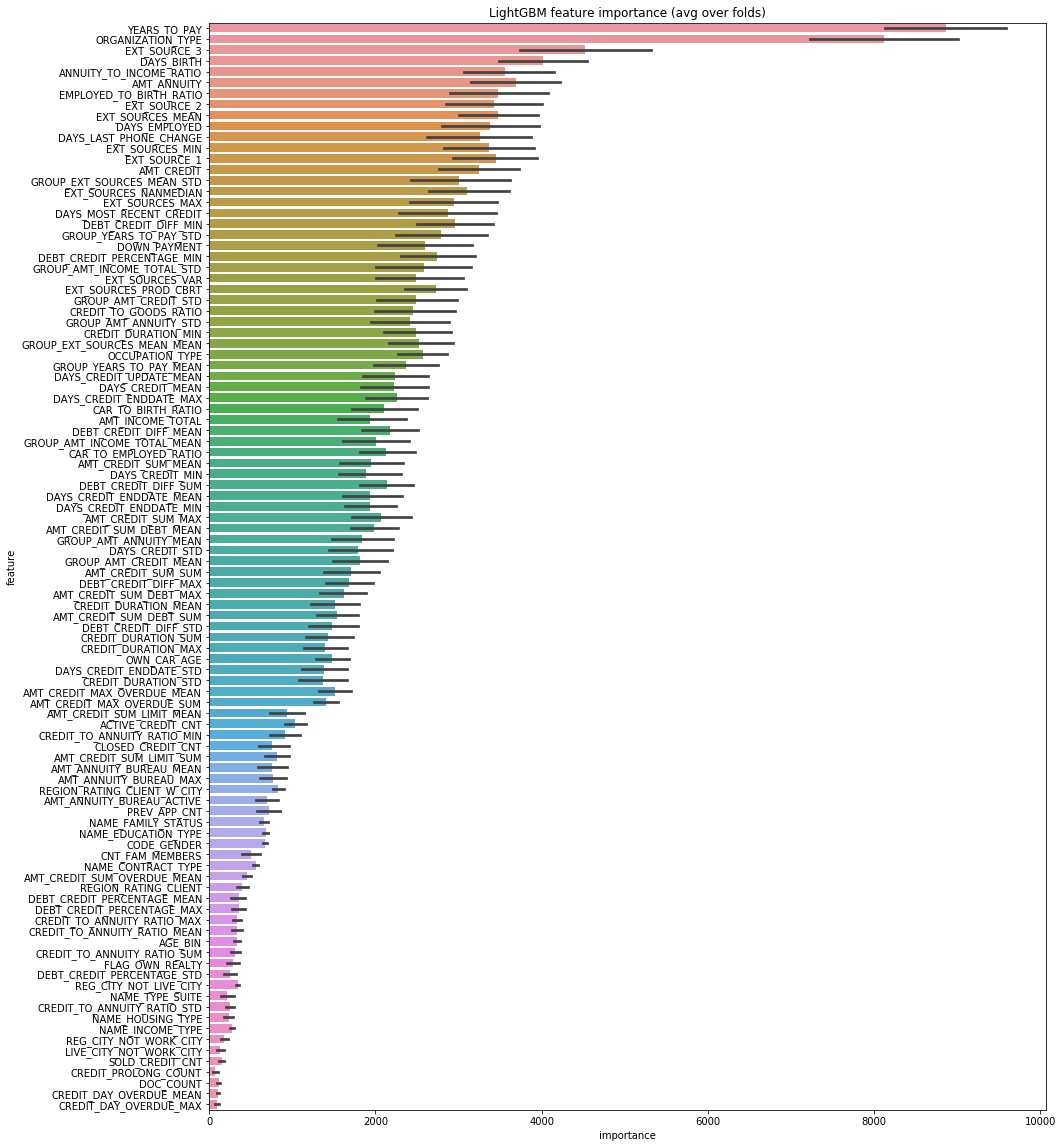

In [75]:
plot_feat_importance(feat_importance)

In [71]:
appl_train_bureau_proc.drop(columns=['GROUP_EXT_SOURCES_MEAN_MEAN',
  'GROUP_EXT_SOURCES_MEAN_STD' ,
    'GROUP_AMT_INCOME_TOTAL_MEAN' ,
    'GROUP_AMT_INCOME_TOTAL_STD',
    'GROUP_YEARS_TO_PAY_MEAN',
    'GROUP_YEARS_TO_PAY_STD',
    'GROUP_AMT_CREDIT_MEAN',
    'GROUP_AMT_CREDIT_STD',
    'GROUP_AMT_ANNUITY_MEAN',
    'GROUP_AMT_ANNUITY_STD'], axis=1, inplace=True)

In [70]:
def get_age_bin(age):
    age_years = age/-365
    if age_years < 25: return 1
    elif age_years < 35: return 2
    elif age_years < 45: return 3
    elif age_years < 60: return 4
    elif age_years < 90: return 5
    else: return 0
    
appl_train_bureau_proc['AGE_BIN'] = appl_train_bureau_proc['DAYS_BIRTH'].apply(lambda x: get_age_bin(x))

In [72]:
# Groupby: Statistics for applications in the same group
group = ['ORGANIZATION_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE','AGE_BIN', 'CODE_GENDER']

group_features = {
     'EXT_SOURCES_MEAN': ['mean', 'std'],
     'AMT_INCOME_TOTAL': ['mean', 'std'],
     'YEARS_TO_PAY': ['mean', 'std'],
     'AMT_CREDIT': ['mean', 'std'],
     'AMT_ANNUITY': ['mean', 'std'],
}

appl_train_bureau_proc, stat_group_features =  apply_agg(appl_train_bureau_proc, group_features, 'SK_ID_CURR', 'GROUP')